In [6]:
from __future__ import print_function
import pickle
from sms import sendMessage
import os
import sys
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from model import capsules
from loss import SpreadLoss
from torch import utils
from torch.utils.data import Dataset, TensorDataset, DataLoader
#########################
seed = 1
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#########################
batch_size, test_batch_size =32 , 1
init_lr = 1e-3 # moein - according to openreview
weight_decay = 2e-7  # moein - according to openreview
log_interval = 10
test_interval = 1
epochs = 500
snapshot_folder = 'yale_face_weights'
test_code = False # moein - for checking the functions. If True, model will run one step.
log_test = False # moein - for getting logs
#########################

In [7]:
from sklearn.model_selection import train_test_split

def get_setting(size= [80,80]):
#     train_data_dir = 'data\\FaceDataset\\PINS'    
    data_dir = 'data\\CroppedYale'    
    
    train_tfms = transforms.Compose([
                                     transforms.Resize((size[0], size[1])),
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.RandomRotation(10), 
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(contrast=(0.4,0.9),brightness=(150/255)),
#                                      transforms.CenterCrop((size[0],size[1])),
                                     transforms.ToTensor()
                                 ])
    
#     test_tfms = transforms.Compose([transforms.Resize((size[0]+5, size[1]+5)),
#                                      transforms.Grayscale(num_output_channels=1),
#                                      transforms.ColorJitter(contrast=(0.4,0.9)),
#                                      transforms.CenterCrop((size[0],size[1])),
#                                     transforms.ToTensor()
#                                 ])

    ############################################################################
#     train_set = datasets.ImageFolder(train_data_dir,transform=train_tfms)
#     test_set = datasets.ImageFolder(test_data_dir,transform=test_tfms)
    train_full = datasets.ImageFolder(data_dir,transform=train_tfms)    
    targets = train_full.targets
    
    train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=0.2, random_state=seed, shuffle=True, stratify=targets)
    
    train_sampler=torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler=torch.utils.data.SubsetRandomSampler(valid_idx)

    ############################################################################
    train_loader = DataLoader(train_full,sampler=train_sampler,batch_size = batch_size, shuffle=False, num_workers = 8, pin_memory=True)
    test_loader = DataLoader(train_full,sampler=test_sampler,batch_size = test_batch_size, shuffle=False, num_workers = 8, pin_memory=True)
    ############################################################################
#     full_loader=DataLoader(train_full,batch_size = batch_size, shuffle=True, num_workers = 8, pin_memory=True)
#     train_loader=full_loader
    return train_loader, test_loader

In [8]:
image_size = 40 #40

train_loader, test_loader = get_setting([image_size,image_size])
num_class = len(train_loader.dataset.classes)
print(len(train_loader)*batch_size+len(test_loader)*test_batch_size,num_class)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\CroppedYale'

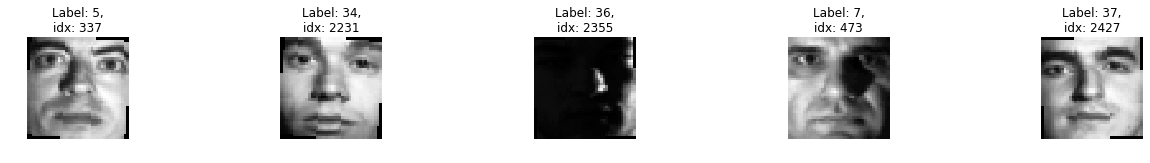

In [61]:
import random
def plot_gallery(imgs,image_size,num=5,class_idx=False):
    plt.figure(figsize=(20,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_.reshape(img_.shape[1],img_.shape[2]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,image_size,class_idx=False)

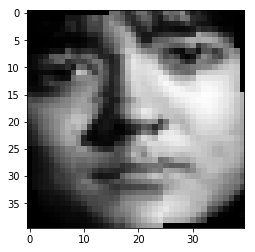

In [62]:
plt.imshow(train_loader.dataset[1947][0].reshape(40,40),cmap='Greys_r')

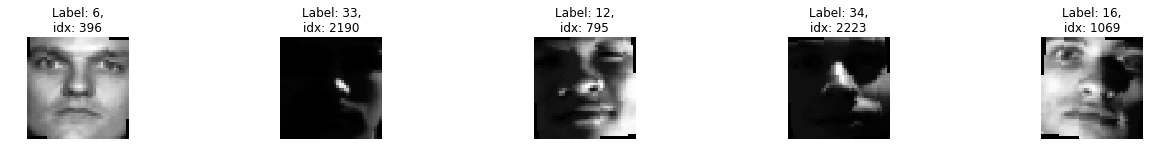

In [63]:
plot_gallery(test_loader.dataset,image_size,class_idx=False)

In [8]:
def loader_labels(loader):
    labels=[]
    for i,(data,label) in enumerate(loader):
        labels.append(label)
    return labels

In [9]:
train_lbls=loader_labels(train_loader)
test_lbls=loader_labels(test_loader)

train_lbls = [item for sublist in train_lbls for item in sublist]
test_lbls = [item for sublist in test_lbls for item in sublist]

In [10]:
def class_distro(lbls):
    number=np.zeros(num_class)
    for l in lbls:
        number[l.item()]+=1
    return number

In [11]:
class_distro(train_lbls)

array([52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 49., 48., 49.,
       51., 50., 51., 51., 52., 52., 52., 52., 52., 52., 52., 52., 52.,
       52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52.])

In [10]:
class_distro(test_lbls)

array([13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 12., 12., 12.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.])

In [70]:
class_distro(test_lbls).sum()

491.0

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs=0, ext_decay= 1):
    
    ''' * exponential learning rate decay added'''
    
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc,epoch_loss = 0,0
    i=0
    for batch_idx, (data, target) in enumerate(train_loader):
        i += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (previous_epochs+epoch-1) * train_len) / ((previous_epochs+epochs)*train_len) # moein - used in criterion
        
        loss = criterion(output, target, r)        
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (previous_epochs + epoch - 1) * len(train_loader) # moein
        exp_lr_decay(optimizer = optimizer, global_step = global_step, ext_decay = ext_decay,init_lr=init_lr) # moein - change the learning rate exponentially
        
        if log_test:
            for param_group in optimizer.param_groups:
                print('optim lr:',param_group['lr'])
                print('step:',global_step)
        
        loss.backward()
        optimizer.step()
        epoch_acc += acc[0].item()
        epoch_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'.format(
                  epoch+previous_epochs, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc[0].item()))
            
        if test_code: return epoch_acc,epoch_loss

    return epoch_acc,epoch_loss

def test(test_loader, model, criterion, device):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        i = 0
        for data, target in test_loader:
            progressBar(job='Test',value=i, endvalue=test_len); i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)[0].item()
            if test_code: return acc

    test_loss /= test_len
    acc /= test_len
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    return acc


In [13]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def snapshot(model, folder, epoch, name):
    path = os.path.join(folder, 'model_{}_{}.pth'.format(name,epoch))
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    print('\nsaving model to {}'.format(path))
    torch.save(model.state_dict(), path)
    
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,ext_decay = 1, staircase=False):
    
    ''' decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)  '''
    
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) * ext_decay
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) * ext_decay
    
#     lr = min(lr, lr_clip)

#     if global_step % decay_steps == 0:
#         print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [14]:
def mainTrain(name, epochs, model, history, optimizer, tolarance = 15, 
              previous_epochs = 0, best_acc= 0, init_decay_fac = 1,LR_decay_fac= 0.1 , best_epoch = 1):
    best_acc = best_acc
    best_epoch = best_epoch
    t, t1 = tolarance , tolarance
    noImp = 0
    decay_factor = init_decay_fac # moein - when training reaches the tolarance threshold, lr will be multiplied by this.
                                # inintial value of it is 1
    print('########### Training model {} ###########'.format(name))
    for epoch in range(1, epochs + 1):
        start=time.time()
        noImp = (epoch + previous_epochs) - best_epoch
        
        acc,loss = train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs,ext_decay=decay_factor)
        acc /= len(train_loader)
        loss /=len(train_loader)

        history['acc'].append(acc)        
        print('Epoch Train-loss : {:.4f}, Epoch Train-accuracy : {:.4f}'.format(loss,acc))
                
        if epoch % test_interval == 0:
            test_acc = test(test_loader, model, criterion, device)
            history['val_acc'].append(test_acc)
            best_acc = max(best_acc,test_acc )
            
            
        snapshot(model, snapshot_folder, epoch+previous_epochs,name)
        
        end=time.time()
        for param_group in optimizer.param_groups:
            print('Current Learning Rate : {}'.format(param_group['lr']))
        
        
        if test_code == True: return best_acc
            
        if test_acc < best_acc:
            tolarance -= 1
            if tolarance < 0:
                print('{} epochs with no improvement since the multiplication. Multiplying LR by {}'.format(t,LR_decay_fac))
                t = t//2 + 3
                tolarance = t # moein - reset tolarence
                decay_factor *= LR_decay_fac 
        else :
            best_epoch = epoch + previous_epochs
            tolarance = t
            
        print('* Best val Accuracy so far : {:.3f} epoch : {} *'.format(best_acc,best_epoch))
        print('Total {} epochs with no improvement in val_acc.'.format(noImp))
        
        if noImp > t1 * 2.5 :
            print('Model has converged. Existing the training.')
            return best_acc
        
        print('Epoch time: {:.2f} mins'.format((end-start)/60))
        print('='*80)

    print('########### Training model {} finished ###########'.format(name))
    return best_acc

In [15]:
device = torch.device("cuda" if cuda else "cpu")
A, B, C, D = 64, 8, 16, 16
# A, B, C, D = 32, 32, 32, 32

criterion = SpreadLoss(num_class=num_class, m_min=0.2, m_max=0.9)

------------------------------------------------------------------------------------

#### model 212


first try best acc 50

In [15]:
# model
torch.cuda.empty_cache()    
best_acc212 = 0
em_iters = [2,1,2]
model212 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history212={'val_acc':[],'acc':[]}
optimizer212 = optim.Adam(model212.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [2, 1, 2] 
stage output:  class_caps 
activation:  o


In [16]:
best_acc212= mainTrain('model212_A',epochs,model212,history212,optimizer212)
print('best test accuracy: {:.6f}'.format(best_acc212))

########### Training model model212_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.237283	Accuracy: 6.250000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.517398	Accuracy: 6.250000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 2.182422	Accuracy: 3.125000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 2.238041	Accuracy: 0.000000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 1.724987	Accuracy: 0.000000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.758156	Accuracy: 0.000000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.634059	Accuracy: 0.000000	
Epoch Train-loss : 1.9789, Epoch Train-accuracy : 3.3042
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.591781, Accuracy: 3.278329 


saving model to yale_face_weights\model_model212_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.278 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.410827	Accuracy: 3.125000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.516679	Accuracy: 15.625000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.826347	Accuracy: 9.375000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.867256	Accuracy: 3.125000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.847574	Accuracy: 6.250000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.650497	Accuracy: 9.375000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.785767	Accuracy: 9.375000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.922456	Accuracy: 9.375000	
Epoch Train-loss : 1.7352, Epoch Train-accuracy : 9.4534
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.290296, Accuracy: 8.900409 


saving model to yale_face_weights\model_model212_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 10.731 epoch : 9 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.678174	Accuracy: 12.500000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.994273	Accuracy: 15.625000	
Train Epo

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.812697	Accuracy: 18.750000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.990585	Accuracy: 12.500000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.886725	Accuracy: 9.375000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.578427	Accuracy: 18.750000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.989120	Accuracy: 18.750000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 2.018108	Accuracy: 15.625000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.528479	Accuracy: 28.125000	
Epoch Train-loss : 1.7586, Epoch Train-accuracy : 21.0293
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.356602, Accuracy: 19.275701 


saving model to yale_face_weights\model_model212_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 19.517 epoch : 16 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.853068	Accuracy: 9.375000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.596032	Accuracy: 25.000000	
Tr

Train Epoch: 28	[0/2452 (0%)]	Loss: 1.805069	Accuracy: 25.000000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.300700	Accuracy: 46.875000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.775281	Accuracy: 21.875000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.924185	Accuracy: 12.500000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.425427	Accuracy: 34.375000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.882378	Accuracy: 31.250000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.419064	Accuracy: 37.500000	
Epoch Train-loss : 1.7406, Epoch Train-accuracy : 29.6035
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.937829, Accuracy: 26.659244 


saving model to yale_face_weights\model_model212_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 26.659 epoch : 28 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.528867	Accuracy: 37.500000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.757955	Accuracy: 21.875000	


Train Epoch: 37	[0/2452 (0%)]	Loss: 1.767860	Accuracy: 31.250000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 2.357688	Accuracy: 25.000000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 2.224933	Accuracy: 25.000000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 1.936447	Accuracy: 43.750000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.749642	Accuracy: 28.125000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 2.048486	Accuracy: 31.250000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 1.689755	Accuracy: 43.750000	
Epoch Train-loss : 1.7815, Epoch Train-accuracy : 35.0694
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.863028, Accuracy: 30.094553 


saving model to yale_face_weights\model_model212_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 33.021 epoch : 36 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 1.833719	Accuracy: 40.625000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 2.032424	Accuracy: 34.375000	


Train Epoch: 46	[0/2452 (0%)]	Loss: 1.855272	Accuracy: 40.625000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 1.797977	Accuracy: 50.000000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.952583	Accuracy: 43.750000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 1.673213	Accuracy: 40.625000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 2.016988	Accuracy: 34.375000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.752019	Accuracy: 50.000000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 1.822955	Accuracy: 37.500000	
Epoch Train-loss : 1.8646, Epoch Train-accuracy : 40.3786
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.059126, Accuracy: 37.700788 


saving model to yale_face_weights\model_model212_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 37.823 epoch : 45 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 2.036134	Accuracy: 37.500000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 2.279591	Accuracy: 21.875000	
T

Train Epoch: 55	[0/2452 (0%)]	Loss: 1.500648	Accuracy: 71.875000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 2.627908	Accuracy: 46.875000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.970101	Accuracy: 50.000000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 2.118644	Accuracy: 53.125000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 2.047691	Accuracy: 46.875000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 1.910357	Accuracy: 46.875000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 1.957395	Accuracy: 62.500000	
Epoch Train-loss : 1.9776, Epoch Train-accuracy : 46.2310
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.103002, Accuracy: 39.462252 


saving model to yale_face_weights\model_model212_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 45.318 epoch : 54 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.834200	Accuracy: 46.875000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 2.149565	Accuracy: 43.750000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 2.213215	Accuracy: 62.500000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 2.640592	Accuracy: 46.875000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 1.740393	Accuracy: 56.250000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 1.876615	Accuracy: 53.125000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 2.095890	Accuracy: 46.875000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 1.996712	Accuracy: 59.375000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 2.086256	Accuracy: 56.250000	
Epoch Train-loss : 2.2295, Epoch Train-accuracy : 48.4263
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.159308, Accuracy: 45.666618 


saving model to yale_face_weights\model_model212_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 48.516 epoch : 63 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 2.324925	Accuracy: 53.125000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 2.501872	Accuracy: 46.875000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 2.057945	Accuracy: 53.125000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 2.246551	Accuracy: 46.875000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 2.668317	Accuracy: 56.250000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 2.629267	Accuracy: 31.250000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 2.390864	Accuracy: 50.000000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 2.756386	Accuracy: 59.375000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 2.458669	Accuracy: 53.125000	
Epoch Train-loss : 2.4079, Epoch Train-accuracy : 51.4505
Test Completion: [-------------->     ] 75%
Test set: Average loss: 16.847989, Accuracy: 50.511098 


saving model to yale_face_weights\model_model212_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 50.511 epoch : 73 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 2.290487	Accuracy: 59.375000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 2.622239	Accuracy: 43.750000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 2.321208	Accuracy: 65.625000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 2.655023	Accuracy: 59.375000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 2.275517	Accuracy: 50.000000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 2.317875	Accuracy: 59.375000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 2.116224	Accuracy: 78.125000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 2.344155	Accuracy: 59.375000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 2.238710	Accuracy: 68.750000	
Epoch Train-loss : 2.5727, Epoch Train-accuracy : 55.5276
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.725947, Accuracy: 56.087543 


saving model to yale_face_weights\model_model212_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 56.517 epoch : 80 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 2.758793	Accuracy: 65.625000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 3.407368	Accuracy: 50.000000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 3.404181	Accuracy: 56.250000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 2.732230	Accuracy: 65.625000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 3.174727	Accuracy: 53.125000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 2.370282	Accuracy: 65.625000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 2.761447	Accuracy: 75.000000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 3.133223	Accuracy: 46.875000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 2.765439	Accuracy: 65.625000	
Epoch Train-loss : 2.8175, Epoch Train-accuracy : 59.4646
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.062739, Accuracy: 56.010879 


saving model to yale_face_weights\model_model212_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 58.274 epoch : 84 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 2.682925	Accuracy: 56.250000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 2.921835	Accuracy: 56.250000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 3.280683	Accuracy: 59.375000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 2.376834	Accuracy: 62.500000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 2.535410	Accuracy: 65.625000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 2.774201	Accuracy: 68.750000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 3.055938	Accuracy: 56.250000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 3.030474	Accuracy: 68.750000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 3.306310	Accuracy: 53.125000	
Epoch Train-loss : 3.0848, Epoch Train-accuracy : 62.4104
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.408137, Accuracy: 60.579731 


saving model to yale_face_weights\model_model212_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 61.200 epoch : 92 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 3.305580	Accuracy: 50.000000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 2.360139	Accuracy: 6

Train Epoch: 117	[960/2452 (48%)]	Loss: 3.534919	Accuracy: 71.875000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 3.008825	Accuracy: 81.250000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 3.920384	Accuracy: 68.750000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 3.996891	Accuracy: 59.375000	
Epoch Train-loss : 3.7292, Epoch Train-accuracy : 66.8515
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.387348, Accuracy: 64.011391 


saving model to yale_face_weights\model_model212_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 64.636 epoch : 112 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 3.381671	Accuracy: 68.750000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 3.567379	Accuracy: 78.125000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 3.262141	Accuracy: 75.000000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 3.826194	Accuracy: 59.375000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 4.094910	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 3.385308	Accuracy: 81.250000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 3.557318	Accuracy: 71.875000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 3.291698	Accuracy: 78.125000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 3.891128	Accuracy: 71.875000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 4.990642	Accuracy: 53.125000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 5.126193	Accuracy: 46.875000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 3.383953	Accuracy: 78.125000	
Epoch Train-loss : 4.2277, Epoch Train-accuracy : 68.9964
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.163736, Accuracy: 64.670341 


saving model to yale_face_weights\model_model212_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 67.604 epoch : 121 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 4.095246	Accuracy: 68.750000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 4.210813	Accuracy: 6

Train Epoch: 143	[960/2452 (48%)]	Loss: 4.834444	Accuracy: 71.875000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 4.398623	Accuracy: 75.000000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 4.992596	Accuracy: 75.000000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 4.744003	Accuracy: 75.000000	
Epoch Train-loss : 4.9622, Epoch Train-accuracy : 75.6048
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.899531, Accuracy: 70.062428 


saving model to yale_face_weights\model_model212_A_143.pth
Current Learning Rate : 0.0009820663662511245
* Best val Accuracy so far : 70.488 epoch : 138 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 4.276243	Accuracy: 78.125000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 4.636886	Accuracy: 65.625000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 5.053301	Accuracy: 71.875000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 5.591496	Accuracy: 53.125000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 4.963904	Accura

Train Epoch: 152	[0/2452 (0%)]	Loss: 7.396597	Accuracy: 56.250000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 6.129779	Accuracy: 65.625000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 6.095393	Accuracy: 78.125000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 5.507964	Accuracy: 71.875000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 5.063264	Accuracy: 75.000000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 5.013008	Accuracy: 84.375000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 5.327909	Accuracy: 71.875000	
Epoch Train-loss : 5.7734, Epoch Train-accuracy : 73.9639
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.747079, Accuracy: 72.451811 


saving model to yale_face_weights\model_model212_A_152.pth
Current Learning Rate : 0.0009809484945345957
* Best val Accuracy so far : 72.643 epoch : 147 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 6.184607	Accuracy: 84.375000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 5.211551	Accuracy: 

Train Epoch: 169	[960/2452 (48%)]	Loss: 7.708889	Accuracy: 75.000000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 8.754455	Accuracy: 59.375000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 6.585888	Accuracy: 87.500000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 7.119887	Accuracy: 78.125000	
Epoch Train-loss : 6.8916, Epoch Train-accuracy : 76.4841
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.478492, Accuracy: 70.686697 


saving model to yale_face_weights\model_model212_A_169.pth
Current Learning Rate : 0.0009788404296643457
* Best val Accuracy so far : 77.132 epoch : 166 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 6.325283	Accuracy: 81.250000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 6.712971	Accuracy: 84.375000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 6.382004	Accuracy: 84.375000	
Train Epoch: 170	[960/2452 (48%)]	Loss: 7.189309	Accuracy: 81.250000	
Train Epoch: 170	[1280/2452 (65%)]	Loss: 6.562876	Accura

Train Epoch: 178	[0/2452 (0%)]	Loss: 6.539401	Accuracy: 87.500000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 6.944058	Accuracy: 81.250000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 7.994583	Accuracy: 87.500000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 7.352952	Accuracy: 90.625000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 8.388190	Accuracy: 78.125000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 7.629937	Accuracy: 75.000000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 7.568794	Accuracy: 75.000000	
Epoch Train-loss : 7.5107, Epoch Train-accuracy : 80.5948
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.923949, Accuracy: 73.696699 


saving model to yale_face_weights\model_model212_A_178.pth
Current Learning Rate : 0.0009777262299840394
* Best val Accuracy so far : 77.439 epoch : 176 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 179	[0/2452 (0%)]	Loss: 7.045346	Accuracy: 87.500000	
Train Epoch: 179	[320/2452 (16%)]	Loss: 7.845035	Accuracy: 

Train Epoch: 195	[960/2452 (48%)]	Loss: 10.457569	Accuracy: 78.125000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 9.091963	Accuracy: 81.250000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 10.251025	Accuracy: 71.875000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 9.501968	Accuracy: 81.250000	
Epoch Train-loss : 9.3043, Epoch Train-accuracy : 80.3539
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.408703, Accuracy: 77.672314 


saving model to yale_face_weights\model_model212_A_195.pth
Current Learning Rate : 0.0009756250897818424
* Best val Accuracy so far : 79.120 epoch : 194 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 196	[0/2452 (0%)]	Loss: 9.177594	Accuracy: 87.500000	
Train Epoch: 196	[320/2452 (16%)]	Loss: 9.699765	Accuracy: 84.375000	
Train Epoch: 196	[640/2452 (32%)]	Loss: 9.534199	Accuracy: 84.375000	
Train Epoch: 196	[960/2452 (48%)]	Loss: 9.078339	Accuracy: 84.375000	
Train Epoch: 196	[1280/2452 (65%)]	Loss: 8.530319	Accu

In [23]:
best_acc212= mainTrain('model212_A',epochs,model212,history212,optimizer212,best_acc=79.740435,
                       best_epoch=196,previous_epochs=200)
print('best test accuracy: {:.6f}'.format(best_acc212))

########### Training model model212_A ###########
Train Epoch: 201	[0/2452 (0%)]	Loss: 0.685382	Accuracy: 71.875000	
Train Epoch: 201	[320/2452 (16%)]	Loss: 0.343330	Accuracy: 87.500000	
Train Epoch: 201	[640/2452 (32%)]	Loss: 0.526783	Accuracy: 84.375000	
Train Epoch: 201	[960/2452 (48%)]	Loss: 0.365611	Accuracy: 75.000000	
Train Epoch: 201	[1280/2452 (65%)]	Loss: 0.263134	Accuracy: 87.500000	
Train Epoch: 201	[1600/2452 (81%)]	Loss: 0.576974	Accuracy: 78.125000	
Train Epoch: 201	[1920/2452 (97%)]	Loss: 0.829008	Accuracy: 87.500000	
Epoch Train-loss : 0.4785, Epoch Train-accuracy : 81.3676
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.331713, Accuracy: 79.116165 


saving model to yale_face_weights\model_model212_A_201.pth
Current Learning Rate : 0.0009748845894498516
* Best val Accuracy so far : 79.740 epoch : 196 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 202	[0/2452 (0%)]	Loss: 0.233177	Accuracy: 87.500000	
Train Epo

Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.163124, Accuracy: 81.965538 


saving model to yale_face_weights\model_model212_A_209.pth
Current Learning Rate : 0.0009738981298852311
* Best val Accuracy so far : 81.966 epoch : 209 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 210	[0/2452 (0%)]	Loss: 0.435182	Accuracy: 78.125000	
Train Epoch: 210	[320/2452 (16%)]	Loss: 0.569414	Accuracy: 81.250000	
Train Epoch: 210	[640/2452 (32%)]	Loss: 0.713608	Accuracy: 68.750000	
Train Epoch: 210	[960/2452 (48%)]	Loss: 0.215008	Accuracy: 96.875000	
Train Epoch: 210	[1280/2452 (65%)]	Loss: 0.600636	Accuracy: 90.625000	
Train Epoch: 210	[1600/2452 (81%)]	Loss: 0.446181	Accuracy: 78.125000	
Train Epoch: 210	[1920/2452 (97%)]	Loss: 0.312197	Accuracy: 84.375000	
Epoch Train-loss : 0.4404, Epoch Train-accuracy : 83.5125
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.360129, Accuracy: 79.231163 


saving model to yale_fac

Train Epoch: 218	[960/2452 (48%)]	Loss: 0.813562	Accuracy: 87.500000	
Train Epoch: 218	[1280/2452 (65%)]	Loss: 0.282127	Accuracy: 93.750000	
Train Epoch: 218	[1600/2452 (81%)]	Loss: 0.325913	Accuracy: 75.000000	
Train Epoch: 218	[1920/2452 (97%)]	Loss: 1.366355	Accuracy: 68.750000	
Epoch Train-loss : 0.4550, Epoch Train-accuracy : 85.3327
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.379570, Accuracy: 81.892523 


saving model to yale_face_weights\model_model212_A_218.pth
Current Learning Rate : 0.0009727895559521527
* Best val Accuracy so far : 83.961 epoch : 215 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 219	[0/2452 (0%)]	Loss: 0.319067	Accuracy: 87.500000	
Train Epoch: 219	[320/2452 (16%)]	Loss: 0.261417	Accuracy: 90.625000	
Train Epoch: 219	[640/2452 (32%)]	Loss: 0.366229	Accuracy: 90.625000	
Train Epoch: 219	[960/2452 (48%)]	Loss: 0.641905	Accuracy: 84.375000	
Train Epoch: 219	[1280/2452 (65%)]	Loss: 0.394540	Accura

Train Epoch: 227	[0/2452 (0%)]	Loss: 0.447710	Accuracy: 87.500000	
Train Epoch: 227	[320/2452 (16%)]	Loss: 0.687085	Accuracy: 90.625000	
Train Epoch: 227	[640/2452 (32%)]	Loss: 0.547188	Accuracy: 90.625000	
Train Epoch: 227	[960/2452 (48%)]	Loss: 0.338233	Accuracy: 87.500000	
Train Epoch: 227	[1280/2452 (65%)]	Loss: 0.350655	Accuracy: 78.125000	
Train Epoch: 227	[1600/2452 (81%)]	Loss: 0.317791	Accuracy: 84.375000	
Train Epoch: 227	[1920/2452 (97%)]	Loss: 0.407758	Accuracy: 90.625000	
Epoch Train-loss : 0.4847, Epoch Train-accuracy : 85.5063
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.509046, Accuracy: 78.495546 


saving model to yale_face_weights\model_model212_A_227.pth
Current Learning Rate : 0.0009716822438924956
* Best val Accuracy so far : 85.948 epoch : 223 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.83 mins
Train Epoch: 228	[0/2452 (0%)]	Loss: 0.511643	Accuracy: 93.750000	
Train Epoch: 228	[320/2452 (16%)]	Loss: 0.544627	Accuracy: 

Train Epoch: 244	[320/2452 (16%)]	Loss: 0.785978	Accuracy: 81.250000	
Train Epoch: 244	[640/2452 (32%)]	Loss: 0.507078	Accuracy: 84.375000	
Train Epoch: 244	[960/2452 (48%)]	Loss: 0.396124	Accuracy: 81.250000	
Train Epoch: 244	[1280/2452 (65%)]	Loss: 0.387838	Accuracy: 90.625000	
Train Epoch: 244	[1600/2452 (81%)]	Loss: 0.609235	Accuracy: 84.375000	
Train Epoch: 244	[1920/2452 (97%)]	Loss: 0.448166	Accuracy: 84.375000	
Epoch Train-loss : 0.4901, Epoch Train-accuracy : 87.7464
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.194223, Accuracy: 82.283148 


saving model to yale_face_weights\model_model212_A_244.pth
Current Learning Rate : 9.695940922568001e-05
* Best val Accuracy so far : 85.948 epoch : 223 *
Total 21 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 245	[0/2452 (0%)]	Loss: 0.383744	Accuracy: 84.375000	
Train Epoch: 245	[320/2452 (16%)]	Loss: 0.415945	Accuracy: 87.500000	
Train Epoch: 245	[640/2452 (32%)]	Loss: 0.590249	Accura

Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.168888, Accuracy: 83.566370 


saving model to yale_face_weights\model_model212_A_252.pth
Current Learning Rate : 9.686129860043712e-06
* Best val Accuracy so far : 85.948 epoch : 223 *
Total 29 epochs with no improvement in val_acc.
Epoch time: 0.82 mins
Train Epoch: 253	[0/2452 (0%)]	Loss: 0.631560	Accuracy: 93.750000	
Train Epoch: 253	[320/2452 (16%)]	Loss: 0.578300	Accuracy: 96.875000	
Train Epoch: 253	[640/2452 (32%)]	Loss: 0.854794	Accuracy: 93.750000	
Train Epoch: 253	[960/2452 (48%)]	Loss: 0.978260	Accuracy: 78.125000	
Train Epoch: 253	[1280/2452 (65%)]	Loss: 0.738783	Accuracy: 84.375000	
Train Epoch: 253	[1600/2452 (81%)]	Loss: 0.445328	Accuracy: 93.750000	
Train Epoch: 253	[1920/2452 (97%)]	Loss: 0.500509	Accuracy: 93.750000	
Epoch Train-loss : 0.5300, Epoch Train-accuracy : 88.5529
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.254785, Accuracy: 81.892523 


saving model to yale_fa

Train Epoch: 261	[320/2452 (16%)]	Loss: 0.387023	Accuracy: 87.500000	
Train Epoch: 261	[640/2452 (32%)]	Loss: 0.488694	Accuracy: 90.625000	
Train Epoch: 261	[960/2452 (48%)]	Loss: 0.604485	Accuracy: 90.625000	
Train Epoch: 261	[1280/2452 (65%)]	Loss: 0.331614	Accuracy: 93.750000	
Train Epoch: 261	[1600/2452 (81%)]	Loss: 0.574969	Accuracy: 87.500000	
Train Epoch: 261	[1920/2452 (97%)]	Loss: 0.805464	Accuracy: 81.250000	
Epoch Train-loss : 0.5624, Epoch Train-accuracy : 87.6456
Test Completion: [-------------->     ] 75%
Test set: Average loss: 9.993281, Accuracy: 83.060747 


saving model to yale_face_weights\model_model212_A_261.pth
Current Learning Rate : 9.675104280729249e-07
* Best val Accuracy so far : 85.948 epoch : 223 *
Total 38 epochs with no improvement in val_acc.
Model has converged. Existing the training.
best test accuracy: 85.948452


In [24]:
with open('model212_A_history_yale.pkl','wb') as f:
    pickle.dump(history212,f)
torch.cuda.empty_cache()    

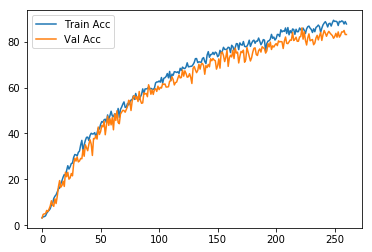

In [25]:
plt.plot(history212['acc'])
plt.plot(history212['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 85.948 epoch : 223 *


=====================================================

#### model 2 2 2

In [16]:
# model
torch.cuda.empty_cache()    
best_acc222 = 0
em_iters = [2,2,2]
model222 = capsules(A=A, B=B, C=C, D=D, E=num_class
                    ,iters_routings=em_iters
                   ).to(device)
history222={'val_acc':[],'acc':[]}
optimizer222 = optim.Adam(model222.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [2, 2, 2] 
stage output:  class_caps 
activation:  o


In [17]:
torch.cuda.empty_cache()
# model222.load_state_dict(torch.load('face_weights\\model_model222_A_55.pth'))
best_acc222= mainTrain('model222_A',epochs,model222,history222,optimizer222)

########### Training model model222_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.370921	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.127640	Accuracy: 3.125000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 1.877580	Accuracy: 0.000000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.810480	Accuracy: 0.000000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 2.042677	Accuracy: 3.125000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.838100	Accuracy: 3.125000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.676460	Accuracy: 0.000000	
Epoch Train-loss : 1.9209, Epoch Train-accuracy : 3.0802
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.858207, Accuracy: 3.783952 


saving model to yale_face_weights\model_model222_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.784 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.578116	Accuracy: 3.125000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.369273	Accuracy: 12.500000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.540467	Accuracy: 6.250000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.578054	Accuracy: 9.375000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.633446	Accuracy: 9.375000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.712554	Accuracy: 3.125000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.584487	Accuracy: 6.250000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.652078	Accuracy: 6.250000	
Epoch Train-loss : 1.5287, Epoch Train-accuracy : 6.5804
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.950921, Accuracy: 7.184579 


saving model to yale_face_weights\model_model222_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 7.338 epoch : 9 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.358315	Accuracy: 12.500000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.869966	Accuracy: 6.250000	
Train Epoch

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.304966	Accuracy: 15.625000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.679713	Accuracy: 9.375000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.490644	Accuracy: 9.375000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.350965	Accuracy: 9.375000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.393939	Accuracy: 12.500000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.648772	Accuracy: 6.250000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.301290	Accuracy: 15.625000	
Epoch Train-loss : 1.4333, Epoch Train-accuracy : 14.1745
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.375496, Accuracy: 13.971232 


saving model to yale_face_weights\model_model222_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 13.971 epoch : 19 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.337696	Accuracy: 6.250000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.357238	Accuracy: 21.875000	
Train

Train Epoch: 28	[0/2452 (0%)]	Loss: 1.333313	Accuracy: 18.750000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.046905	Accuracy: 21.875000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.415954	Accuracy: 12.500000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.596776	Accuracy: 15.625000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.196640	Accuracy: 31.250000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.496979	Accuracy: 21.875000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.169428	Accuracy: 18.750000	
Epoch Train-loss : 1.3389, Epoch Train-accuracy : 21.7630
Test Completion: [-------------->     ] 75%
Test set: Average loss: 25.881949, Accuracy: 20.684872 


saving model to yale_face_weights\model_model222_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 20.685 epoch : 28 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.265181	Accuracy: 21.875000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.434131	Accuracy: 9.375000	
T

Train Epoch: 37	[0/2452 (0%)]	Loss: 1.212381	Accuracy: 28.125000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 1.444823	Accuracy: 12.500000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.340128	Accuracy: 21.875000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 1.278158	Accuracy: 34.375000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.221294	Accuracy: 28.125000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 1.407808	Accuracy: 12.500000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 0.895572	Accuracy: 37.500000	
Epoch Train-loss : 1.2288, Epoch Train-accuracy : 25.8737
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.177650, Accuracy: 23.694874 


saving model to yale_face_weights\model_model222_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 24.901 epoch : 31 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 1.220252	Accuracy: 18.750000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 1.527975	Accuracy: 31.250000	


Train Epoch: 46	[0/2452 (0%)]	Loss: 1.231899	Accuracy: 31.250000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 0.968064	Accuracy: 28.125000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.426880	Accuracy: 25.000000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 0.794720	Accuracy: 25.000000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 1.183306	Accuracy: 15.625000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.057778	Accuracy: 43.750000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 1.097057	Accuracy: 25.000000	
Epoch Train-loss : 1.1294, Epoch Train-accuracy : 30.7012
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.727863, Accuracy: 29.658295 


saving model to yale_face_weights\model_model222_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 29.658 epoch : 46 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 1.393800	Accuracy: 25.000000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 1.262035	Accuracy: 34.375000	
T

Train Epoch: 55	[0/2452 (0%)]	Loss: 0.886009	Accuracy: 43.750000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 1.132533	Accuracy: 31.250000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.126315	Accuracy: 37.500000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 1.024291	Accuracy: 34.375000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 0.993201	Accuracy: 34.375000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 0.991727	Accuracy: 28.125000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 0.915649	Accuracy: 43.750000	
Epoch Train-loss : 1.0530, Epoch Train-accuracy : 37.1752
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.180768, Accuracy: 32.710280 


saving model to yale_face_weights\model_model222_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 37.390 epoch : 51 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.205230	Accuracy: 25.000000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 1.180438	Accuracy: 34.375000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 1.036741	Accuracy: 37.500000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 1.206334	Accuracy: 40.625000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 0.696580	Accuracy: 46.875000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 0.859145	Accuracy: 37.500000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 0.854266	Accuracy: 31.250000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 0.970511	Accuracy: 37.500000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.277585	Accuracy: 37.500000	
Epoch Train-loss : 1.0453, Epoch Train-accuracy : 40.0538
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.417741, Accuracy: 33.920488 


saving model to yale_face_weights\model_model222_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 37.823 epoch : 59 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 1.130838	Accuracy: 34.375000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 0.905353	Accuracy: 53.125000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 0.948711	Accuracy: 40.625000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 0.980646	Accuracy: 34.375000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 1.112131	Accuracy: 46.875000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 1.397498	Accuracy: 28.125000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 1.180655	Accuracy: 53.125000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 1.079669	Accuracy: 50.000000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 1.197119	Accuracy: 50.000000	
Epoch Train-loss : 1.0066, Epoch Train-accuracy : 42.9828
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.111255, Accuracy: 36.532564 


saving model to yale_face_weights\model_model222_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 41.331 epoch : 72 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 0.793607	Accuracy: 59.375000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 1.084011	Accuracy: 28.125000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 0.928076	Accuracy: 53.125000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 0.967920	Accuracy: 34.375000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 0.891838	Accuracy: 56.250000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 0.905183	Accuracy: 37.500000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 0.915989	Accuracy: 43.750000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 0.701191	Accuracy: 59.375000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 0.815987	Accuracy: 56.250000	
Epoch Train-loss : 0.9939, Epoch Train-accuracy : 45.6709
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.048606, Accuracy: 46.842144 


saving model to yale_face_weights\model_model222_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 46.842 epoch : 82 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 0.949024	Accuracy: 46.875000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 0.958761	Accuracy: 37.500000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 1.142139	Accuracy: 59.375000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 0.939177	Accuracy: 59.375000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 1.110610	Accuracy: 43.750000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 0.666034	Accuracy: 62.500000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 0.865804	Accuracy: 53.125000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 1.001599	Accuracy: 46.875000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 0.760831	Accuracy: 59.375000	
Epoch Train-loss : 0.9165, Epoch Train-accuracy : 52.0777
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.181740, Accuracy: 46.095575 


saving model to yale_face_weights\model_model222_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 47.264 epoch : 90 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 0.997092	Accuracy: 46.875000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 0.935735	Accuracy: 46.875000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 1.048960	Accuracy: 40.625000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 0.599173	Accuracy: 62.500000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 0.771728	Accuracy: 43.750000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 0.912951	Accuracy: 50.000000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 0.883848	Accuracy: 56.250000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 0.764747	Accuracy: 62.500000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 0.841714	Accuracy: 53.125000	
Epoch Train-loss : 0.9336, Epoch Train-accuracy : 53.6962
Test Completion: [-------------->     ] 75%
Test set: Average loss: 16.766268, Accuracy: 44.031104 


saving model to yale_face_weights\model_model222_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 50.779 epoch : 95 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 1.525302	Accuracy: 40.625000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 0.686207	Accuracy: 6

Train Epoch: 117	[960/2452 (48%)]	Loss: 0.975049	Accuracy: 50.000000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 0.767789	Accuracy: 65.625000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 0.962544	Accuracy: 59.375000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 0.916019	Accuracy: 59.375000	
Epoch Train-loss : 0.9429, Epoch Train-accuracy : 56.4124
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.726392, Accuracy: 51.916618 


saving model to yale_face_weights\model_model222_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 55.578 epoch : 110 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 0.976554	Accuracy: 71.875000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 0.726536	Accuracy: 62.500000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 1.132507	Accuracy: 56.250000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 1.068176	Accuracy: 56.250000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 1.329908	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 0.755144	Accuracy: 71.875000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 0.621571	Accuracy: 50.000000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 0.861598	Accuracy: 50.000000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 0.829213	Accuracy: 71.875000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 1.620755	Accuracy: 40.625000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 0.938936	Accuracy: 43.750000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 0.492706	Accuracy: 84.375000	
Epoch Train-loss : 0.9958, Epoch Train-accuracy : 57.8461
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.268619, Accuracy: 53.081191 


saving model to yale_face_weights\model_model222_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 57.221 epoch : 121 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 0.714197	Accuracy: 53.125000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 1.028105	Accuracy: 5

Train Epoch: 143	[960/2452 (48%)]	Loss: 0.828223	Accuracy: 65.625000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 0.710094	Accuracy: 62.500000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 0.817211	Accuracy: 62.500000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 0.791902	Accuracy: 71.875000	
Epoch Train-loss : 0.9771, Epoch Train-accuracy : 64.3313
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.226508, Accuracy: 56.439837 


saving model to yale_face_weights\model_model222_A_143.pth
Current Learning Rate : 0.0009820663662511245
* Best val Accuracy so far : 60.928 epoch : 139 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 0.766311	Accuracy: 59.375000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 0.645698	Accuracy: 65.625000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 1.041895	Accuracy: 62.500000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 0.864870	Accuracy: 56.250000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 1.149731	Accura

Train Epoch: 152	[0/2452 (0%)]	Loss: 1.149632	Accuracy: 65.625000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 0.980389	Accuracy: 59.375000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 1.473583	Accuracy: 43.750000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 0.714830	Accuracy: 71.875000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 0.911707	Accuracy: 71.875000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 0.808404	Accuracy: 65.625000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 0.885116	Accuracy: 68.750000	
Epoch Train-loss : 1.0212, Epoch Train-accuracy : 63.2280
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.846474, Accuracy: 56.171510 


saving model to yale_face_weights\model_model222_A_152.pth
Current Learning Rate : 0.0009809484945345957
* Best val Accuracy so far : 61.434 epoch : 151 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 1.031538	Accuracy: 65.625000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 1.017316	Accuracy: 

Train Epoch: 169	[960/2452 (48%)]	Loss: 1.423374	Accuracy: 59.375000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 1.021006	Accuracy: 68.750000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 0.949620	Accuracy: 81.250000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 1.222749	Accuracy: 62.500000	
Epoch Train-loss : 0.9822, Epoch Train-accuracy : 68.0612
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.205201, Accuracy: 58.588274 


saving model to yale_face_weights\model_model222_A_169.pth
Current Learning Rate : 0.0009788404296643457
* Best val Accuracy so far : 63.743 epoch : 168 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 0.877931	Accuracy: 68.750000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 0.882317	Accuracy: 68.750000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 0.845682	Accuracy: 65.625000	
Train Epoch: 170	[960/2452 (48%)]	Loss: 1.118653	Accuracy: 59.375000	
Train Epoch: 170	[1280/2452 (65%)]	Loss: 1.236679	Accura

Train Epoch: 178	[0/2452 (0%)]	Loss: 0.722327	Accuracy: 75.000000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 1.109661	Accuracy: 65.625000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 1.819298	Accuracy: 59.375000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 1.267479	Accuracy: 75.000000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 1.494195	Accuracy: 68.750000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 1.223199	Accuracy: 56.250000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 1.370831	Accuracy: 68.750000	
Epoch Train-loss : 1.1116, Epoch Train-accuracy : 67.6859
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.815716, Accuracy: 64.876606 


saving model to yale_face_weights\model_model222_A_178.pth
Current Learning Rate : 0.0009777262299840394
* Best val Accuracy so far : 64.877 epoch : 178 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 179	[0/2452 (0%)]	Loss: 0.904630	Accuracy: 81.250000	
Train Epoch: 179	[320/2452 (16%)]	Loss: 1.007682	Accuracy: 

Train Epoch: 195	[960/2452 (48%)]	Loss: 1.292143	Accuracy: 59.375000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 0.893329	Accuracy: 71.875000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 1.129250	Accuracy: 71.875000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 1.082782	Accuracy: 62.500000	
Epoch Train-loss : 1.1263, Epoch Train-accuracy : 70.3853
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.903848, Accuracy: 66.979410 


saving model to yale_face_weights\model_model222_A_195.pth
Current Learning Rate : 0.0009756250897818424
* Best val Accuracy so far : 66.979 epoch : 195 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 196	[0/2452 (0%)]	Loss: 1.063041	Accuracy: 71.875000	
Train Epoch: 196	[320/2452 (16%)]	Loss: 0.966177	Accuracy: 71.875000	
Train Epoch: 196	[640/2452 (32%)]	Loss: 1.240045	Accuracy: 75.000000	
Train Epoch: 196	[960/2452 (48%)]	Loss: 1.054459	Accuracy: 65.625000	
Train Epoch: 196	[1280/2452 (65%)]	Loss: 1.023546	Accura

Train Epoch: 204	[0/2452 (0%)]	Loss: 0.903138	Accuracy: 75.000000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 1.065377	Accuracy: 68.750000	
Train Epoch: 204	[640/2452 (32%)]	Loss: 0.922901	Accuracy: 71.875000	
Train Epoch: 204	[960/2452 (48%)]	Loss: 1.135346	Accuracy: 50.000000	
Train Epoch: 204	[1280/2452 (65%)]	Loss: 1.184097	Accuracy: 71.875000	
Train Epoch: 204	[1600/2452 (81%)]	Loss: 1.876383	Accuracy: 68.750000	
Train Epoch: 204	[1920/2452 (97%)]	Loss: 1.030991	Accuracy: 81.250000	
Epoch Train-loss : 1.1563, Epoch Train-accuracy : 70.0549
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.909931, Accuracy: 63.195458 


saving model to yale_face_weights\model_model222_A_204.pth
Current Learning Rate : 0.0009745145500756855
* Best val Accuracy so far : 66.979 epoch : 195 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 205	[0/2452 (0%)]	Loss: 0.844166	Accuracy: 75.000000	
Train Epoch: 205	[320/2452 (16%)]	Loss: 0.954187	Accuracy: 

Train Epoch: 221	[960/2452 (48%)]	Loss: 1.189164	Accuracy: 71.875000	
Train Epoch: 221	[1280/2452 (65%)]	Loss: 0.919766	Accuracy: 71.875000	
Train Epoch: 221	[1600/2452 (81%)]	Loss: 1.324466	Accuracy: 78.125000	
Train Epoch: 221	[1920/2452 (97%)]	Loss: 0.977515	Accuracy: 81.250000	
Epoch Train-loss : 1.1817, Epoch Train-accuracy : 72.8495
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.499728, Accuracy: 68.457943 


saving model to yale_face_weights\model_model222_A_221.pth
Current Learning Rate : 0.0009724203117950748
* Best val Accuracy so far : 70.491 epoch : 213 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 222	[0/2452 (0%)]	Loss: 0.883659	Accuracy: 81.250000	
Train Epoch: 222	[320/2452 (16%)]	Loss: 0.736954	Accuracy: 78.125000	
Train Epoch: 222	[640/2452 (32%)]	Loss: 0.954426	Accuracy: 75.000000	
Train Epoch: 222	[960/2452 (48%)]	Loss: 0.878036	Accuracy: 81.250000	
Train Epoch: 222	[1280/2452 (65%)]	Loss: 1.458524	Accura

Train Epoch: 230	[0/2452 (0%)]	Loss: 1.045417	Accuracy: 71.875000	
Train Epoch: 230	[320/2452 (16%)]	Loss: 1.526488	Accuracy: 65.625000	
Train Epoch: 230	[640/2452 (32%)]	Loss: 1.113398	Accuracy: 75.000000	
Train Epoch: 230	[960/2452 (48%)]	Loss: 1.170729	Accuracy: 78.125000	
Train Epoch: 230	[1280/2452 (65%)]	Loss: 0.982047	Accuracy: 75.000000	
Train Epoch: 230	[1600/2452 (81%)]	Loss: 1.619376	Accuracy: 68.750000	
Train Epoch: 230	[1920/2452 (97%)]	Loss: 1.539473	Accuracy: 65.625000	
Epoch Train-loss : 1.1933, Epoch Train-accuracy : 74.4904
Test Completion: [-------------->     ] 75%
Test set: Average loss: 11.162796, Accuracy: 66.477439 


saving model to yale_face_weights\model_model222_A_230.pth
Current Learning Rate : 9.71313420040617e-05
* Best val Accuracy so far : 70.491 epoch : 213 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 0.93 mins
Train Epoch: 231	[0/2452 (0%)]	Loss: 1.584615	Accuracy: 65.625000	
Train Epoch: 231	[320/2452 (16%)]	Loss: 1.288425	Accuracy: 

Train Epoch: 247	[960/2452 (48%)]	Loss: 1.348385	Accuracy: 78.125000	
Train Epoch: 247	[1280/2452 (65%)]	Loss: 1.107818	Accuracy: 84.375000	
Train Epoch: 247	[1600/2452 (81%)]	Loss: 1.140156	Accuracy: 75.000000	
Train Epoch: 247	[1920/2452 (97%)]	Loss: 1.301627	Accuracy: 78.125000	
Epoch Train-loss : 1.3004, Epoch Train-accuracy : 77.5426
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.645103, Accuracy: 73.846378 


saving model to yale_face_weights\model_model222_A_247.pth
Current Learning Rate : 9.692260610098439e-05
* Best val Accuracy so far : 74.624 epoch : 240 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 248	[0/2452 (0%)]	Loss: 1.057422	Accuracy: 71.875000	
Train Epoch: 248	[320/2452 (16%)]	Loss: 1.195247	Accuracy: 71.875000	
Train Epoch: 248	[640/2452 (32%)]	Loss: 1.557329	Accuracy: 75.000000	
Train Epoch: 248	[960/2452 (48%)]	Loss: 1.167042	Accuracy: 75.000000	
Train Epoch: 248	[1280/2452 (65%)]	Loss: 1.245102	Accura

Train Epoch: 256	[0/2452 (0%)]	Loss: 1.190985	Accuracy: 84.375000	
Train Epoch: 256	[320/2452 (16%)]	Loss: 1.278670	Accuracy: 75.000000	
Train Epoch: 256	[640/2452 (32%)]	Loss: 1.500102	Accuracy: 84.375000	
Train Epoch: 256	[960/2452 (48%)]	Loss: 1.374388	Accuracy: 68.750000	
Train Epoch: 256	[1280/2452 (65%)]	Loss: 1.112969	Accuracy: 90.625000	
Train Epoch: 256	[1600/2452 (81%)]	Loss: 1.348643	Accuracy: 78.125000	
Train Epoch: 256	[1920/2452 (97%)]	Loss: 1.037450	Accuracy: 87.500000	
Epoch Train-loss : 1.3816, Epoch Train-accuracy : 78.3490
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.593035, Accuracy: 71.778255 


saving model to yale_face_weights\model_model222_A_256.pth
Current Learning Rate : 9.681228052241262e-06
* Best val Accuracy so far : 74.624 epoch : 240 *
Total 16 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 257	[0/2452 (0%)]	Loss: 1.122914	Accuracy: 81.250000	
Train Epoch: 257	[320/2452 (16%)]	Loss: 1.924365	Accuracy:

Epoch Train-loss : 1.5401, Epoch Train-accuracy : 77.7834
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.992077, Accuracy: 70.923992 


saving model to yale_face_weights\model_model222_A_264.pth
Current Learning Rate : 9.671431877275777e-07
* Best val Accuracy so far : 74.624 epoch : 240 *
Total 24 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 265	[0/2452 (0%)]	Loss: 1.658017	Accuracy: 71.875000	
Train Epoch: 265	[320/2452 (16%)]	Loss: 1.429400	Accuracy: 78.125000	
Train Epoch: 265	[640/2452 (32%)]	Loss: 1.244410	Accuracy: 93.750000	
Train Epoch: 265	[960/2452 (48%)]	Loss: 1.770028	Accuracy: 78.125000	
Train Epoch: 265	[1280/2452 (65%)]	Loss: 1.390008	Accuracy: 90.625000	
Train Epoch: 265	[1600/2452 (81%)]	Loss: 1.131895	Accuracy: 90.625000	
Train Epoch: 265	[1920/2452 (97%)]	Loss: 2.002202	Accuracy: 71.875000	
Epoch Train-loss : 1.5538, Epoch Train-accuracy : 78.2258
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 273	[320/2452 (16%)]	Loss: 1.442665	Accuracy: 75.000000	
Train Epoch: 273	[640/2452 (32%)]	Loss: 1.636347	Accuracy: 75.000000	
Train Epoch: 273	[960/2452 (48%)]	Loss: 1.462404	Accuracy: 78.125000	
Train Epoch: 273	[1280/2452 (65%)]	Loss: 1.871459	Accuracy: 84.375000	
Train Epoch: 273	[1600/2452 (81%)]	Loss: 1.259586	Accuracy: 90.625000	
Train Epoch: 273	[1920/2452 (97%)]	Loss: 1.646675	Accuracy: 75.000000	
Epoch Train-loss : 1.6011, Epoch Train-accuracy : 81.7484
Test Completion: [-------------->     ] 75%
Test set: Average loss: 10.745543, Accuracy: 71.586594 


saving model to yale_face_weights\model_model222_A_273.pth
Current Learning Rate : 9.660423028459162e-08
* Best val Accuracy so far : 74.624 epoch : 240 *
Total 33 epochs with no improvement in val_acc.
Epoch time: 0.94 mins
Train Epoch: 274	[0/2452 (0%)]	Loss: 1.398455	Accuracy: 90.625000	
Train Epoch: 274	[320/2452 (16%)]	Loss: 1.533329	Accuracy: 75.000000	
Train Epoch: 274	[640/2452 (32%)]	Loss: 1.568062	Accura

In [18]:
print('best test accuracy: {:.6f}'.format(best_acc222))
with open('model222_A_history_yale.pkl','wb') as f:
    pickle.dump(history222,f)

best test accuracy: 74.623978


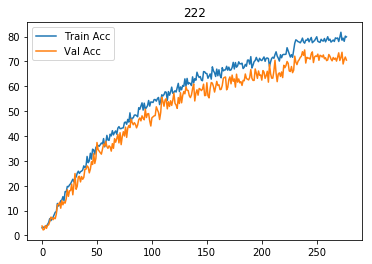

In [19]:
plt.title('222')
plt.plot(history222['acc'])
plt.plot(history222['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 74.624 epoch : 240 *


--------------------------------------------------------------------------------------------------

#### model 112

In [21]:
# model
torch.cuda.empty_cache()
best_acc112 = 0
em_iters = [1,1,2]
model112 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history112={'val_acc':[],'acc':[]}
optimizer112 = optim.Adam(model112.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [1, 1, 2] 
stage output:  class_caps 
activation:  o


In [22]:
torch.cuda.empty_cache()

best_acc112= mainTrain('model112_A',epochs,model112,history112,optimizer112)


########### Training model model112_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.235342	Accuracy: 3.125000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.654000	Accuracy: 6.250000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 1.919303	Accuracy: 0.000000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.735860	Accuracy: 3.125000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 2.233823	Accuracy: 6.250000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.813104	Accuracy: 3.125000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.699180	Accuracy: 0.000000	
Epoch Train-loss : 1.9393, Epoch Train-accuracy : 2.7218
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.925235, Accuracy: 3.316662 


saving model to yale_face_weights\model_model112_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.317 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.75 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.813513	Accuracy: 0.000000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.547080	Accuracy: 9.375000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.481410	Accuracy: 12.500000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.224181	Accuracy: 21.875000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.290140	Accuracy: 6.250000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.462361	Accuracy: 9.375000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.367674	Accuracy: 6.250000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.261091	Accuracy: 18.750000	
Epoch Train-loss : 1.3145, Epoch Train-accuracy : 12.7072
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.693280, Accuracy: 13.147999 


saving model to yale_face_weights\model_model112_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 13.148 epoch : 10 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.278871	Accuracy: 15.625000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.125454	Accuracy: 25.000000	
Trai

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.157006	Accuracy: 25.000000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.148611	Accuracy: 21.875000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.076398	Accuracy: 15.625000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.039462	Accuracy: 28.125000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.151612	Accuracy: 28.125000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.221032	Accuracy: 25.000000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.255155	Accuracy: 15.625000	
Epoch Train-loss : 1.1432, Epoch Train-accuracy : 23.6951
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.189121, Accuracy: 19.007374 


saving model to yale_face_weights\model_model112_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 21.236 epoch : 18 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.132325	Accuracy: 25.000000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.550156	Accuracy: 12.500000	


Train Epoch: 28	[0/2452 (0%)]	Loss: 1.079270	Accuracy: 25.000000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 0.997991	Accuracy: 37.500000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 0.763033	Accuracy: 46.875000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 0.960553	Accuracy: 31.250000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.077751	Accuracy: 34.375000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.037271	Accuracy: 50.000000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.198613	Accuracy: 31.250000	
Epoch Train-loss : 1.0650, Epoch Train-accuracy : 35.3383
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.665230, Accuracy: 31.297459 


saving model to yale_face_weights\model_model112_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 32.082 epoch : 26 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 0.983689	Accuracy: 43.750000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.125073	Accuracy: 34.375000	


Train Epoch: 37	[0/2452 (0%)]	Loss: 0.841460	Accuracy: 56.250000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 0.798508	Accuracy: 46.875000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.098825	Accuracy: 34.375000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 0.997132	Accuracy: 43.750000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.183593	Accuracy: 31.250000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 0.847504	Accuracy: 50.000000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 0.960438	Accuracy: 46.875000	
Epoch Train-loss : 1.0042, Epoch Train-accuracy : 43.1788
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.552996, Accuracy: 36.926840 


saving model to yale_face_weights\model_model112_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 39.658 epoch : 35 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 0.888225	Accuracy: 50.000000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 1.161221	Accuracy: 37.500000	


Train Epoch: 46	[0/2452 (0%)]	Loss: 1.000335	Accuracy: 40.625000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 0.987279	Accuracy: 43.750000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.000706	Accuracy: 43.750000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 1.079697	Accuracy: 40.625000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 0.849928	Accuracy: 59.375000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.083520	Accuracy: 43.750000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 0.932419	Accuracy: 43.750000	
Epoch Train-loss : 0.9872, Epoch Train-accuracy : 46.2590
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.523297, Accuracy: 43.828490 


saving model to yale_face_weights\model_model112_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 44.418 epoch : 39 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 0.912375	Accuracy: 50.000000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 1.274550	Accuracy: 46.875000	
T

Train Epoch: 55	[0/2452 (0%)]	Loss: 0.896539	Accuracy: 46.875000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 0.976956	Accuracy: 46.875000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 0.962687	Accuracy: 46.875000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 0.824777	Accuracy: 65.625000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 1.010919	Accuracy: 56.250000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 0.717494	Accuracy: 75.000000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 0.807084	Accuracy: 50.000000	
Epoch Train-loss : 0.9601, Epoch Train-accuracy : 53.2202
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.472090, Accuracy: 48.163697 


saving model to yale_face_weights\model_model112_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 48.439 epoch : 53 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.131291	Accuracy: 37.500000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 0.915158	Accuracy: 50.000000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 1.119945	Accuracy: 40.625000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 1.317660	Accuracy: 34.375000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 1.033256	Accuracy: 53.125000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 0.886668	Accuracy: 46.875000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 0.888836	Accuracy: 68.750000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 0.865283	Accuracy: 53.125000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.294466	Accuracy: 43.750000	
Epoch Train-loss : 0.9784, Epoch Train-accuracy : 54.8835
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.025208, Accuracy: 53.004527 


saving model to yale_face_weights\model_model112_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 53.632 epoch : 59 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 1.126062	Accuracy: 56.250000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 1.021285	Accuracy: 68.750000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 0.836539	Accuracy: 59.375000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 1.193880	Accuracy: 62.500000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 1.005203	Accuracy: 53.125000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 0.614846	Accuracy: 81.250000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 0.963382	Accuracy: 56.250000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 0.887805	Accuracy: 62.500000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 1.047400	Accuracy: 59.375000	
Epoch Train-loss : 0.9850, Epoch Train-accuracy : 59.2630
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.902311, Accuracy: 53.782126 


saving model to yale_face_weights\model_model112_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 55.777 epoch : 69 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 0.725485	Accuracy: 78.125000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 0.813668	Accuracy: 62.500000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 1.111462	Accuracy: 53.125000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 1.348491	Accuracy: 46.875000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 1.335037	Accuracy: 50.000000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 1.188181	Accuracy: 50.000000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 1.041843	Accuracy: 68.750000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 0.850438	Accuracy: 68.750000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 1.234485	Accuracy: 53.125000	
Epoch Train-loss : 1.0133, Epoch Train-accuracy : 59.7166
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.277070, Accuracy: 59.526504 


saving model to yale_face_weights\model_model112_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 59.527 epoch : 82 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 0.713200	Accuracy: 65.625000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 0.926215	Accuracy: 56.250000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 0.748136	Accuracy: 71.875000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 1.441519	Accuracy: 56.250000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 1.012563	Accuracy: 65.625000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 1.165536	Accuracy: 59.375000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 0.944291	Accuracy: 53.125000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 1.223386	Accuracy: 53.125000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 0.915880	Accuracy: 71.875000	
Epoch Train-loss : 1.0165, Epoch Train-accuracy : 63.0992
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.547806, Accuracy: 61.081703 


saving model to yale_face_weights\model_model112_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 62.024 epoch : 90 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 1.113665	Accuracy: 65.625000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 1.079872	Accuracy: 50.000000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 0.939089	Accuracy: 65.625000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 0.861580	Accuracy: 78.125000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 1.143124	Accuracy: 59.375000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 1.376973	Accuracy: 71.875000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 1.111439	Accuracy: 62.500000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 0.962440	Accuracy: 81.250000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 1.229752	Accuracy: 71.875000	
Epoch Train-loss : 1.0493, Epoch Train-accuracy : 64.9138
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.154749, Accuracy: 60.729410 


saving model to yale_face_weights\model_model112_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 63.701 epoch : 98 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.75 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 1.017973	Accuracy: 62.500000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 1.347453	Accuracy: 5

Train Epoch: 117	[960/2452 (48%)]	Loss: 1.092398	Accuracy: 65.625000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 1.099182	Accuracy: 68.750000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 0.868026	Accuracy: 84.375000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 1.081964	Accuracy: 75.000000	
Epoch Train-loss : 1.1399, Epoch Train-accuracy : 67.7083
Test Completion: [-------------->     ] 75%
Test set: Average loss: 16.990032, Accuracy: 65.186915 


saving model to yale_face_weights\model_model112_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 66.435 epoch : 115 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 0.769266	Accuracy: 87.500000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 1.365384	Accuracy: 53.125000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 1.073082	Accuracy: 59.375000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 1.570940	Accuracy: 62.500000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 1.078718	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 1.357831	Accuracy: 50.000000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 1.429382	Accuracy: 59.375000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 1.317894	Accuracy: 59.375000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 0.937206	Accuracy: 65.625000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 1.586640	Accuracy: 65.625000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 1.137848	Accuracy: 71.875000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 1.109072	Accuracy: 68.750000	
Epoch Train-loss : 1.1677, Epoch Train-accuracy : 68.1340
Test Completion: [-------------->     ] 75%
Test set: Average loss: 16.825563, Accuracy: 64.953271 


saving model to yale_face_weights\model_model112_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 67.213 epoch : 120 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 1.131451	Accuracy: 59.375000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 1.070749	Accuracy: 6

Train Epoch: 143	[960/2452 (48%)]	Loss: 1.240678	Accuracy: 75.000000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 1.065271	Accuracy: 78.125000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 1.532930	Accuracy: 68.750000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 1.151037	Accuracy: 75.000000	
Epoch Train-loss : 1.1827, Epoch Train-accuracy : 72.0990
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.880990, Accuracy: 67.017742 


saving model to yale_face_weights\model_model112_A_143.pth
Current Learning Rate : 0.0009820663662511245
* Best val Accuracy so far : 69.438 epoch : 131 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 1.048567	Accuracy: 65.625000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 1.301221	Accuracy: 81.250000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 1.317587	Accuracy: 62.500000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 1.237021	Accuracy: 78.125000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 1.256003	Accur

Train Epoch: 152	[0/2452 (0%)]	Loss: 1.235645	Accuracy: 62.500000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 1.457827	Accuracy: 65.625000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 1.084205	Accuracy: 78.125000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 0.924575	Accuracy: 78.125000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 0.890051	Accuracy: 78.125000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 1.527345	Accuracy: 71.875000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 1.066495	Accuracy: 78.125000	
Epoch Train-loss : 1.2651, Epoch Train-accuracy : 72.4238
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.441260, Accuracy: 69.323160 


saving model to yale_face_weights\model_model112_A_152.pth
Current Learning Rate : 0.0009809484945345957
* Best val Accuracy so far : 71.897 epoch : 144 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 1.165396	Accuracy: 68.750000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 1.878842	Accuracy: 

Train Epoch: 169	[960/2452 (48%)]	Loss: 1.401111	Accuracy: 71.875000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 1.074032	Accuracy: 78.125000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 1.682441	Accuracy: 62.500000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 1.105245	Accuracy: 75.000000	
Epoch Train-loss : 1.3958, Epoch Train-accuracy : 71.6902
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.499243, Accuracy: 71.035339 


saving model to yale_face_weights\model_model112_A_169.pth
Current Learning Rate : 0.0009788404296643457
* Best val Accuracy so far : 73.881 epoch : 164 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 1.552012	Accuracy: 62.500000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 1.480738	Accuracy: 78.125000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 1.482617	Accuracy: 71.875000	
Train Epoch: 170	[960/2452 (48%)]	Loss: 0.985676	Accuracy: 84.375000	
Train Epoch: 170	[1280/2452 (65%)]	Loss: 1.673017	Accura

Train Epoch: 178	[0/2452 (0%)]	Loss: 1.151423	Accuracy: 81.250000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 1.062756	Accuracy: 93.750000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 1.545385	Accuracy: 78.125000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 1.270784	Accuracy: 71.875000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 1.561873	Accuracy: 71.875000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 2.182579	Accuracy: 65.625000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 1.960350	Accuracy: 68.750000	
Epoch Train-loss : 1.4737, Epoch Train-accuracy : 72.9951
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.375226, Accuracy: 70.334404 


saving model to yale_face_weights\model_model112_A_178.pth
Current Learning Rate : 0.0009777262299840394
* Best val Accuracy so far : 73.881 epoch : 164 *
Total 14 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 179	[0/2452 (0%)]	Loss: 1.272355	Accuracy: 78.125000	
Train Epoch: 179	[320/2452 (16%)]	Loss: 1.013981	Accuracy:

Epoch Train-loss : 1.4443, Epoch Train-accuracy : 76.2825
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.360852, Accuracy: 71.854921 


saving model to yale_face_weights\model_model112_A_186.pth
Current Learning Rate : 9.7673689503959e-05
* Best val Accuracy so far : 76.152 epoch : 182 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 187	[0/2452 (0%)]	Loss: 1.154670	Accuracy: 84.375000	
Train Epoch: 187	[320/2452 (16%)]	Loss: 1.361105	Accuracy: 81.250000	
Train Epoch: 187	[640/2452 (32%)]	Loss: 1.215062	Accuracy: 87.500000	
Train Epoch: 187	[960/2452 (48%)]	Loss: 1.502239	Accuracy: 65.625000	
Train Epoch: 187	[1280/2452 (65%)]	Loss: 1.104330	Accuracy: 90.625000	
Train Epoch: 187	[1600/2452 (81%)]	Loss: 1.534712	Accuracy: 65.625000	
Train Epoch: 187	[1920/2452 (97%)]	Loss: 1.167201	Accuracy: 71.875000	
Epoch Train-loss : 1.4717, Epoch Train-accuracy : 76.2265
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14

Train Epoch: 195	[320/2452 (16%)]	Loss: 1.345360	Accuracy: 75.000000	
Train Epoch: 195	[640/2452 (32%)]	Loss: 1.429850	Accuracy: 75.000000	
Train Epoch: 195	[960/2452 (48%)]	Loss: 2.103458	Accuracy: 53.125000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 1.751697	Accuracy: 78.125000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 1.364034	Accuracy: 81.250000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 2.030909	Accuracy: 65.625000	
Epoch Train-loss : 1.5433, Epoch Train-accuracy : 77.9458
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.132718, Accuracy: 75.646173 


saving model to yale_face_weights\model_model112_A_195.pth
Current Learning Rate : 9.756250897818425e-06
* Best val Accuracy so far : 76.152 epoch : 182 *
Total 13 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 196	[0/2452 (0%)]	Loss: 2.041844	Accuracy: 71.875000	
Train Epoch: 196	[320/2452 (16%)]	Loss: 1.119693	Accuracy: 84.375000	
Train Epoch: 196	[640/2452 (32%)]	Loss: 1.320376	Accura

Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.242595, Accuracy: 76.155447 


saving model to yale_face_weights\model_model112_A_203.pth
Current Learning Rate : 9.746378809248002e-07
* Best val Accuracy so far : 76.155 epoch : 203 *
Total 21 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 204	[0/2452 (0%)]	Loss: 2.112690	Accuracy: 75.000000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 1.426654	Accuracy: 78.125000	
Train Epoch: 204	[640/2452 (32%)]	Loss: 1.693824	Accuracy: 81.250000	
Train Epoch: 204	[960/2452 (48%)]	Loss: 1.422153	Accuracy: 81.250000	
Train Epoch: 204	[1280/2452 (65%)]	Loss: 1.548935	Accuracy: 84.375000	
Train Epoch: 204	[1600/2452 (81%)]	Loss: 2.227759	Accuracy: 65.625000	
Train Epoch: 204	[1920/2452 (97%)]	Loss: 1.539783	Accuracy: 78.125000	
Epoch Train-loss : 1.7215, Epoch Train-accuracy : 76.9601
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.892267, Accuracy: 74.474298 


saving model to yale_fa

Train Epoch: 212	[960/2452 (48%)]	Loss: 1.717934	Accuracy: 78.125000	
Train Epoch: 212	[1280/2452 (65%)]	Loss: 1.879193	Accuracy: 68.750000	
Train Epoch: 212	[1600/2452 (81%)]	Loss: 1.710342	Accuracy: 84.375000	
Train Epoch: 212	[1920/2452 (97%)]	Loss: 1.857824	Accuracy: 87.500000	
Epoch Train-loss : 1.8713, Epoch Train-accuracy : 75.3640
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.269019, Accuracy: 74.313667 


saving model to yale_face_weights\model_model112_A_212.pth
Current Learning Rate : 9.735284649439818e-07
* Best val Accuracy so far : 78.182 epoch : 209 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 213	[0/2452 (0%)]	Loss: 1.957629	Accuracy: 75.000000	
Train Epoch: 213	[320/2452 (16%)]	Loss: 1.999653	Accuracy: 78.125000	
Train Epoch: 213	[640/2452 (32%)]	Loss: 2.245903	Accuracy: 75.000000	
Train Epoch: 213	[960/2452 (48%)]	Loss: 1.851196	Accuracy: 68.750000	
Train Epoch: 213	[1280/2452 (65%)]	Loss: 1.648641	Accura

Train Epoch: 221	[0/2452 (0%)]	Loss: 2.057052	Accuracy: 68.750000	
Train Epoch: 221	[320/2452 (16%)]	Loss: 1.962628	Accuracy: 81.250000	
Train Epoch: 221	[640/2452 (32%)]	Loss: 2.129853	Accuracy: 75.000000	
Train Epoch: 221	[960/2452 (48%)]	Loss: 2.060107	Accuracy: 84.375000	
Train Epoch: 221	[1280/2452 (65%)]	Loss: 1.738945	Accuracy: 84.375000	
Train Epoch: 221	[1600/2452 (81%)]	Loss: 1.615956	Accuracy: 75.000000	
Train Epoch: 221	[1920/2452 (97%)]	Loss: 1.835979	Accuracy: 78.125000	
Epoch Train-loss : 2.0152, Epoch Train-accuracy : 76.8873
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.207035, Accuracy: 74.125656 


saving model to yale_face_weights\model_model112_A_221.pth
Current Learning Rate : 9.724203117950751e-08
* Best val Accuracy so far : 78.182 epoch : 209 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 0.72 mins
Train Epoch: 222	[0/2452 (0%)]	Loss: 2.133843	Accuracy: 71.875000	
Train Epoch: 222	[320/2452 (16%)]	Loss: 1.847935	Accuracy:

Epoch Train-loss : 2.2561, Epoch Train-accuracy : 76.3777
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.997551, Accuracy: 72.088566 


saving model to yale_face_weights\model_model112_A_229.pth
Current Learning Rate : 9.714363457669089e-09
* Best val Accuracy so far : 78.182 epoch : 209 *
Total 20 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 230	[0/2452 (0%)]	Loss: 2.599455	Accuracy: 71.875000	
Train Epoch: 230	[320/2452 (16%)]	Loss: 2.320016	Accuracy: 75.000000	
Train Epoch: 230	[640/2452 (32%)]	Loss: 1.942479	Accuracy: 78.125000	
Train Epoch: 230	[960/2452 (48%)]	Loss: 2.600286	Accuracy: 75.000000	
Train Epoch: 230	[1280/2452 (65%)]	Loss: 2.305153	Accuracy: 75.000000	
Train Epoch: 230	[1600/2452 (81%)]	Loss: 2.569936	Accuracy: 62.500000	
Train Epoch: 230	[1920/2452 (97%)]	Loss: 1.982111	Accuracy: 78.125000	
Epoch Train-loss : 2.2319, Epoch Train-accuracy : 76.0249
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 238	[320/2452 (16%)]	Loss: 2.546426	Accuracy: 71.875000	
Train Epoch: 238	[640/2452 (32%)]	Loss: 1.936018	Accuracy: 81.250000	
Train Epoch: 238	[960/2452 (48%)]	Loss: 2.196035	Accuracy: 75.000000	
Train Epoch: 238	[1280/2452 (65%)]	Loss: 2.324749	Accuracy: 78.125000	
Train Epoch: 238	[1600/2452 (81%)]	Loss: 2.454295	Accuracy: 78.125000	
Train Epoch: 238	[1920/2452 (97%)]	Loss: 2.692379	Accuracy: 71.875000	
Epoch Train-loss : 2.4230, Epoch Train-accuracy : 75.3864
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.877226, Accuracy: 74.547314 


saving model to yale_face_weights\model_model112_A_238.pth
Current Learning Rate : 9.703305740465247e-10
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 78.182 epoch : 209 *
Total 29 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 239	[0/2452 (0%)]	Loss: 2.313395	Accuracy: 81.250000	
Train Epoch: 239	[320/2452 (16%)]	Loss: 2.576785

Epoch Train-loss : 2.5814, Epoch Train-accuracy : 78.1754
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.080079, Accuracy: 71.582943 


saving model to yale_face_weights\model_model112_A_246.pth
Current Learning Rate : 9.693487225679288e-12
* Best val Accuracy so far : 78.182 epoch : 209 *
Total 37 epochs with no improvement in val_acc.
Epoch time: 0.73 mins
Train Epoch: 247	[0/2452 (0%)]	Loss: 2.579877	Accuracy: 78.125000	
Train Epoch: 247	[320/2452 (16%)]	Loss: 2.270534	Accuracy: 78.125000	
Train Epoch: 247	[640/2452 (32%)]	Loss: 2.850674	Accuracy: 71.875000	
Train Epoch: 247	[960/2452 (48%)]	Loss: 2.513127	Accuracy: 84.375000	
Train Epoch: 247	[1280/2452 (65%)]	Loss: 2.754483	Accuracy: 68.750000	
Train Epoch: 247	[1600/2452 (81%)]	Loss: 2.501560	Accuracy: 75.000000	
Train Epoch: 247	[1920/2452 (97%)]	Loss: 2.829390	Accuracy: 65.625000	
Epoch Train-loss : 2.6581, Epoch Train-accuracy : 75.5544
Test Completion: [-------------->     ] 75%
Test set: Average loss:

best test accuracy: 78.181585


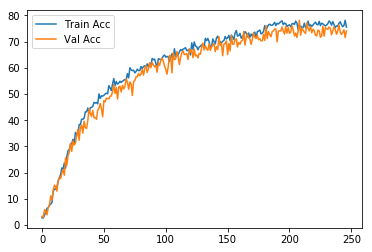

In [23]:
print('best test accuracy: {:.6f}'.format(best_acc112))
with open('model112_A_history_yale.pkl','wb') as f:
    pickle.dump(history112,f)
torch.cuda.empty_cache()    

plt.plot(history112['acc'])
plt.plot(history112['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()


* Best val Accuracy so far : 78.182 epoch : 209 *


=====================================================

#### model 113

In [24]:
# model
torch.cuda.empty_cache()
best_acc113 = 0
em_iters = [1,1,3]
model113 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history113={'val_acc':[],'acc':[]}
optimizer113 = optim.Adam(model113.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [1, 1, 3] 
stage output:  class_caps 
activation:  o


In [25]:
torch.cuda.empty_cache()

best_acc113= mainTrain('model113_A',epochs,model113,history113,optimizer113)


########### Training model model113_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.674379	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.534382	Accuracy: 0.000000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 2.941058	Accuracy: 3.125000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.867336	Accuracy: 3.125000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 2.221525	Accuracy: 3.125000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 2.570008	Accuracy: 0.000000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.646214	Accuracy: 3.125000	
Epoch Train-loss : 2.3655, Epoch Train-accuracy : 2.4474
Test Completion: [-------------->     ] 75%
Test set: Average loss: 30.413774, Accuracy: 3.201665 


saving model to yale_face_weights\model_model113_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.202 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.644402	Accuracy: 0.000000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.325189	Accuracy: 3.125000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.567187	Accuracy: 9.375000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.552737	Accuracy: 15.625000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.498248	Accuracy: 3.125000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.617438	Accuracy: 9.375000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.691829	Accuracy: 3.125000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.317413	Accuracy: 6.250000	
Epoch Train-loss : 1.5100, Epoch Train-accuracy : 7.4653
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.821214, Accuracy: 8.237807 


saving model to yale_face_weights\model_model113_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 8.238 epoch : 10 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.460679	Accuracy: 12.500000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.347327	Accuracy: 15.625000	
Train Epo

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.579098	Accuracy: 9.375000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.364694	Accuracy: 12.500000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.202879	Accuracy: 21.875000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.467666	Accuracy: 12.500000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 0.953030	Accuracy: 21.875000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.211267	Accuracy: 15.625000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.251373	Accuracy: 18.750000	
Epoch Train-loss : 1.3500, Epoch Train-accuracy : 15.9554
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.495284, Accuracy: 15.771028 


saving model to yale_face_weights\model_model113_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 16.200 epoch : 18 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.005404	Accuracy: 43.750000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.503167	Accuracy: 6.250000	
Tr

Train Epoch: 28	[0/2452 (0%)]	Loss: 1.285611	Accuracy: 18.750000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.180041	Accuracy: 12.500000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.067640	Accuracy: 28.125000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.371105	Accuracy: 15.625000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 0.979043	Accuracy: 34.375000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.030273	Accuracy: 21.875000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.213219	Accuracy: 34.375000	
Epoch Train-loss : 1.2114, Epoch Train-accuracy : 23.1631
Test Completion: [-------------->     ] 75%
Test set: Average loss: 25.415886, Accuracy: 22.327687 


saving model to yale_face_weights\model_model113_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 22.910 epoch : 25 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.451962	Accuracy: 21.875000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.309090	Accuracy: 9.375000	
T

Train Epoch: 37	[0/2452 (0%)]	Loss: 1.038819	Accuracy: 37.500000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 1.072582	Accuracy: 34.375000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.009266	Accuracy: 21.875000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 0.921803	Accuracy: 25.000000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.003947	Accuracy: 28.125000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 0.916522	Accuracy: 34.375000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 1.105956	Accuracy: 12.500000	
Epoch Train-loss : 1.1445, Epoch Train-accuracy : 31.2276
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.955031, Accuracy: 30.684141 


saving model to yale_face_weights\model_model113_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 30.684 epoch : 37 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 1.112859	Accuracy: 46.875000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 1.446197	Accuracy: 46.875000	


Train Epoch: 46	[0/2452 (0%)]	Loss: 1.000932	Accuracy: 43.750000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 0.981960	Accuracy: 50.000000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.050985	Accuracy: 37.500000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 1.595361	Accuracy: 21.875000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 1.094352	Accuracy: 40.625000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.105721	Accuracy: 34.375000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 0.881399	Accuracy: 43.750000	
Epoch Train-loss : 1.1295, Epoch Train-accuracy : 37.8136
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.911719, Accuracy: 32.518619 


saving model to yale_face_weights\model_model113_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 34.506 epoch : 45 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 1.103506	Accuracy: 37.500000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 0.927567	Accuracy: 43.750000	
T

Train Epoch: 55	[0/2452 (0%)]	Loss: 1.006195	Accuracy: 46.875000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 1.302247	Accuracy: 37.500000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.084506	Accuracy: 50.000000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 1.148021	Accuracy: 28.125000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 1.026476	Accuracy: 50.000000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 1.038310	Accuracy: 50.000000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 1.257100	Accuracy: 50.000000	
Epoch Train-loss : 1.0998, Epoch Train-accuracy : 42.3443
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.179106, Accuracy: 36.846524 


saving model to yale_face_weights\model_model113_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 37.666 epoch : 49 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.191582	Accuracy: 28.125000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 1.106718	Accuracy: 53.125000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 1.405986	Accuracy: 40.625000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 1.022138	Accuracy: 50.000000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 1.392948	Accuracy: 37.500000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 1.134711	Accuracy: 40.625000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 1.009135	Accuracy: 40.625000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 1.377540	Accuracy: 25.000000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.321151	Accuracy: 50.000000	
Epoch Train-loss : 1.2115, Epoch Train-accuracy : 43.9964
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.946023, Accuracy: 41.492042 


saving model to yale_face_weights\model_model113_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 41.492 epoch : 64 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 0.916953	Accuracy: 53.125000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 0.913459	Accuracy: 53.125000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 1.127539	Accuracy: 53.125000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 1.102971	Accuracy: 46.875000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 0.907590	Accuracy: 53.125000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 1.150989	Accuracy: 43.750000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 1.510080	Accuracy: 37.500000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 0.996128	Accuracy: 59.375000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 1.092501	Accuracy: 34.375000	
Epoch Train-loss : 1.1297, Epoch Train-accuracy : 49.2496
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.228497, Accuracy: 38.719334 


saving model to yale_face_weights\model_model113_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 44.575 epoch : 70 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 1.029179	Accuracy: 56.250000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 0.890797	Accuracy: 62.500000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 1.168475	Accuracy: 40.625000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 1.192811	Accuracy: 43.750000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 1.058611	Accuracy: 46.875000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 1.217005	Accuracy: 56.250000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 1.131184	Accuracy: 56.250000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 0.983658	Accuracy: 68.750000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 1.208594	Accuracy: 46.875000	
Epoch Train-loss : 1.1981, Epoch Train-accuracy : 50.0168
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.767508, Accuracy: 40.048189 


saving model to yale_face_weights\model_model113_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 49.297 epoch : 79 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 1.170250	Accuracy: 59.375000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 1.370150	Accuracy: 37.500000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 1.047262	Accuracy: 59.375000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 1.263859	Accuracy: 46.875000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 1.779510	Accuracy: 43.750000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 1.626275	Accuracy: 43.750000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 1.349103	Accuracy: 65.625000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 1.088326	Accuracy: 59.375000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 0.976722	Accuracy: 56.250000	
Epoch Train-loss : 1.2468, Epoch Train-accuracy : 51.4393
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.162478, Accuracy: 44.188084 


saving model to yale_face_weights\model_model113_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 49.297 epoch : 79 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 1.091732	Accuracy: 46.875000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 0.957169	Accuracy: 46.875000	


Train Epoch: 100	[0/2452 (0%)]	Loss: 1.372476	Accuracy: 46.875000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 1.131430	Accuracy: 65.625000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 1.230024	Accuracy: 56.250000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 1.194569	Accuracy: 56.250000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 1.316254	Accuracy: 56.250000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 0.994432	Accuracy: 50.000000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 1.187541	Accuracy: 50.000000	
Epoch Train-loss : 1.2160, Epoch Train-accuracy : 54.1219
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.371439, Accuracy: 48.048700 


saving model to yale_face_weights\model_model113_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 51.446 epoch : 99 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.75 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 1.036140	Accuracy: 59.375000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 1.269805	Accuracy: 6

Train Epoch: 117	[960/2452 (48%)]	Loss: 1.269790	Accuracy: 56.250000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 1.168445	Accuracy: 59.375000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 1.249885	Accuracy: 68.750000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 1.183330	Accuracy: 50.000000	
Epoch Train-loss : 1.2661, Epoch Train-accuracy : 57.1685
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.586515, Accuracy: 51.954950 


saving model to yale_face_weights\model_model113_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 54.330 epoch : 106 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 1.286231	Accuracy: 59.375000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 1.163801	Accuracy: 56.250000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 1.296134	Accuracy: 59.375000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 1.086333	Accuracy: 62.500000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 1.287539	Accur

Train Epoch: 126	[0/2452 (0%)]	Loss: 0.889694	Accuracy: 75.000000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 1.568622	Accuracy: 53.125000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 1.147704	Accuracy: 65.625000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 1.442358	Accuracy: 37.500000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 1.387694	Accuracy: 62.500000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 1.325042	Accuracy: 62.500000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 1.422072	Accuracy: 46.875000	
Epoch Train-loss : 1.2180, Epoch Train-accuracy : 63.8273
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.694978, Accuracy: 55.267962 


saving model to yale_face_weights\model_model113_A_126.pth
Current Learning Rate : 9.84181378610859e-05
* Best val Accuracy so far : 55.268 epoch : 126 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 1.463179	Accuracy: 59.375000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 1.082961	Accuracy: 6

Train Epoch: 143	[960/2452 (48%)]	Loss: 1.394465	Accuracy: 65.625000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 1.569018	Accuracy: 65.625000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 1.692887	Accuracy: 59.375000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 1.350836	Accuracy: 62.500000	
Epoch Train-loss : 1.4146, Epoch Train-accuracy : 62.9424
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.776050, Accuracy: 55.152965 


saving model to yale_face_weights\model_model113_A_143.pth
Current Learning Rate : 9.820663662511245e-05
* Best val Accuracy so far : 57.570 epoch : 137 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 1.276215	Accuracy: 65.625000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 1.512975	Accuracy: 75.000000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 1.597557	Accuracy: 68.750000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 1.361444	Accuracy: 65.625000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 1.555086	Accura

Train Epoch: 152	[0/2452 (0%)]	Loss: 1.354042	Accuracy: 68.750000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 1.496148	Accuracy: 71.875000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 1.665995	Accuracy: 59.375000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 1.683508	Accuracy: 59.375000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 1.804133	Accuracy: 50.000000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 1.858043	Accuracy: 59.375000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 1.513310	Accuracy: 65.625000	
Epoch Train-loss : 1.6014, Epoch Train-accuracy : 63.0656
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.812453, Accuracy: 57.098788 


saving model to yale_face_weights\model_model113_A_152.pth
Current Learning Rate : 9.809484945345959e-06
* Best val Accuracy so far : 59.132 epoch : 150 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 1.520074	Accuracy: 68.750000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 1.956949	Accuracy: 

Epoch Train-loss : 1.6611, Epoch Train-accuracy : 64.9642
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.664735, Accuracy: 54.647342 


saving model to yale_face_weights\model_model113_A_160.pth
Current Learning Rate : 9.799558990670854e-07
* Best val Accuracy so far : 59.132 epoch : 150 *
Total 10 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 161	[0/2452 (0%)]	Loss: 1.727200	Accuracy: 59.375000	
Train Epoch: 161	[320/2452 (16%)]	Loss: 1.661973	Accuracy: 50.000000	
Train Epoch: 161	[640/2452 (32%)]	Loss: 1.403785	Accuracy: 68.750000	
Train Epoch: 161	[960/2452 (48%)]	Loss: 1.658510	Accuracy: 65.625000	
Train Epoch: 161	[1280/2452 (65%)]	Loss: 1.728711	Accuracy: 75.000000	
Train Epoch: 161	[1600/2452 (81%)]	Loss: 1.796444	Accuracy: 62.500000	
Train Epoch: 161	[1920/2452 (97%)]	Loss: 1.797820	Accuracy: 68.750000	
Epoch Train-loss : 1.7276, Epoch Train-accuracy : 63.9505
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 169	[320/2452 (16%)]	Loss: 1.783724	Accuracy: 68.750000	
Train Epoch: 169	[640/2452 (32%)]	Loss: 2.090914	Accuracy: 65.625000	
Train Epoch: 169	[960/2452 (48%)]	Loss: 2.287686	Accuracy: 46.875000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 1.737050	Accuracy: 56.250000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 1.768664	Accuracy: 71.875000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 1.767764	Accuracy: 75.000000	
Epoch Train-loss : 1.8624, Epoch Train-accuracy : 65.5746
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.770650, Accuracy: 54.762340 


saving model to yale_face_weights\model_model113_A_169.pth
Current Learning Rate : 9.78840429664346e-08
* Best val Accuracy so far : 59.561 epoch : 168 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 1.987525	Accuracy: 65.625000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 1.863267	Accuracy: 68.750000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 1.653613	Accuracy

Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.696980, Accuracy: 58.117333 


saving model to yale_face_weights\model_model113_A_177.pth
Current Learning Rate : 9.778499672911288e-09
* Best val Accuracy so far : 59.561 epoch : 168 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 178	[0/2452 (0%)]	Loss: 1.711904	Accuracy: 68.750000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 1.578876	Accuracy: 78.125000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 2.352360	Accuracy: 43.750000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 2.089256	Accuracy: 62.500000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 1.935501	Accuracy: 78.125000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 2.173888	Accuracy: 62.500000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 1.944494	Accuracy: 65.625000	
Epoch Train-loss : 2.0018, Epoch Train-accuracy : 66.1738
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.559783, Accuracy: 54.880987 


saving model to yale_fac

Train Epoch: 186	[320/2452 (16%)]	Loss: 2.390397	Accuracy: 56.250000	
Train Epoch: 186	[640/2452 (32%)]	Loss: 2.388295	Accuracy: 59.375000	
Train Epoch: 186	[960/2452 (48%)]	Loss: 2.727210	Accuracy: 68.750000	
Train Epoch: 186	[1280/2452 (65%)]	Loss: 2.005448	Accuracy: 62.500000	
Train Epoch: 186	[1600/2452 (81%)]	Loss: 1.706306	Accuracy: 68.750000	
Train Epoch: 186	[1920/2452 (97%)]	Loss: 2.775690	Accuracy: 56.250000	
Epoch Train-loss : 2.2386, Epoch Train-accuracy : 63.7265
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.744712, Accuracy: 52.655885 


saving model to yale_face_weights\model_model113_A_186.pth
Current Learning Rate : 9.767368950395903e-10
* Best val Accuracy so far : 59.561 epoch : 168 *
Total 18 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 187	[0/2452 (0%)]	Loss: 1.846822	Accuracy: 84.375000	
Train Epoch: 187	[320/2452 (16%)]	Loss: 2.126511	Accuracy: 68.750000	
Train Epoch: 187	[640/2452 (32%)]	Loss: 1.786586	Accura

Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.882428, Accuracy: 54.329731 


saving model to yale_face_weights\model_model113_A_194.pth
Current Learning Rate : 9.757485611766319e-11
* Best val Accuracy so far : 59.561 epoch : 168 *
Total 26 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 195	[0/2452 (0%)]	Loss: 1.873041	Accuracy: 81.250000	
Train Epoch: 195	[320/2452 (16%)]	Loss: 2.374368	Accuracy: 75.000000	
Train Epoch: 195	[640/2452 (32%)]	Loss: 2.131364	Accuracy: 65.625000	
Train Epoch: 195	[960/2452 (48%)]	Loss: 3.286763	Accuracy: 43.750000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 2.834651	Accuracy: 59.375000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 2.471190	Accuracy: 62.500000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 2.231373	Accuracy: 65.625000	
Epoch Train-loss : 2.4156, Epoch Train-accuracy : 63.9785
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.618458, Accuracy: 58.431293 


saving model to yale_fa

Train Epoch: 203	[320/2452 (16%)]	Loss: 2.267239	Accuracy: 65.625000	
Train Epoch: 203	[640/2452 (32%)]	Loss: 2.623710	Accuracy: 71.875000	
Train Epoch: 203	[960/2452 (48%)]	Loss: 2.975162	Accuracy: 65.625000	
Train Epoch: 203	[1280/2452 (65%)]	Loss: 3.113420	Accuracy: 50.000000	
Train Epoch: 203	[1600/2452 (81%)]	Loss: 2.820209	Accuracy: 62.500000	
Train Epoch: 203	[1920/2452 (97%)]	Loss: 2.379283	Accuracy: 65.625000	
Epoch Train-loss : 2.5983, Epoch Train-accuracy : 64.2305
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.857672, Accuracy: 52.341925 


saving model to yale_face_weights\model_model113_A_203.pth
Current Learning Rate : 9.746378809248006e-12
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 59.561 epoch : 168 *
Total 35 epochs with no improvement in val_acc.
Epoch time: 0.76 mins
Train Epoch: 204	[0/2452 (0%)]	Loss: 2.493097	Accuracy: 59.375000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 1.933969

best test accuracy: 59.561186


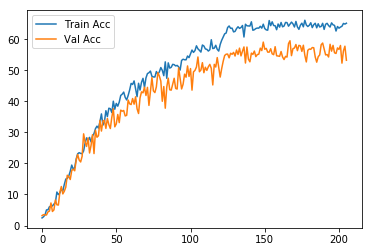

In [26]:
print('best test accuracy: {:.6f}'.format(best_acc113))
with open('model113_A_history_yale.pkl','wb') as f:
    pickle.dump(history113,f)
torch.cuda.empty_cache()    

plt.plot(history113['acc'])
plt.plot(history113['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 59.561 epoch : 168 *


=====================================================

#### model 122

In [27]:
# model
torch.cuda.empty_cache()
best_acc122 = 0
em_iters = [1,2,2]
model122 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history122={'val_acc':[],'acc':[]}
optimizer122 = optim.Adam(model122.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [1, 2, 2] 
stage output:  class_caps 
activation:  o


In [28]:
torch.cuda.empty_cache()

best_acc122= mainTrain('model122_A',epochs,model122,history122,optimizer122)

########### Training model model122_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.393529	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.771386	Accuracy: 6.250000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 2.222563	Accuracy: 0.000000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.682683	Accuracy: 3.125000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 1.780949	Accuracy: 3.125000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.657252	Accuracy: 3.125000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.659733	Accuracy: 3.125000	
Epoch Train-loss : 1.9437, Epoch Train-accuracy : 3.3042
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.886325, Accuracy: 3.044685 


saving model to yale_face_weights\model_model122_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.045 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.807086	Accuracy: 0.000000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.313778	Accuracy: 9.375000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.497893	Accuracy: 9.375000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.376470	Accuracy: 3.125000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.486205	Accuracy: 9.375000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.557324	Accuracy: 15.625000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.401952	Accuracy: 12.500000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.431697	Accuracy: 6.250000	
Epoch Train-loss : 1.3973, Epoch Train-accuracy : 11.4975
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.294414, Accuracy: 9.991968 


saving model to yale_face_weights\model_model122_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 9.992 epoch : 10 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.433137	Accuracy: 15.625000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.528942	Accuracy: 9.375000	
Train Ep

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.120497	Accuracy: 31.250000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.159151	Accuracy: 21.875000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.043477	Accuracy: 25.000000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.151879	Accuracy: 15.625000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.101251	Accuracy: 15.625000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.205274	Accuracy: 21.875000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.186191	Accuracy: 21.875000	
Epoch Train-loss : 1.1671, Epoch Train-accuracy : 24.0255
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.209697, Accuracy: 20.960499 


saving model to yale_face_weights\model_model122_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 21.466 epoch : 18 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.166964	Accuracy: 21.875000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.190873	Accuracy: 21.875000	


Train Epoch: 28	[0/2452 (0%)]	Loss: 1.087154	Accuracy: 25.000000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.028368	Accuracy: 34.375000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.098431	Accuracy: 43.750000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 0.992166	Accuracy: 25.000000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.041021	Accuracy: 34.375000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.406341	Accuracy: 28.125000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.215195	Accuracy: 28.125000	
Epoch Train-loss : 1.0250, Epoch Train-accuracy : 33.5461
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.287847, Accuracy: 31.374124 


saving model to yale_face_weights\model_model122_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 31.374 epoch : 28 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.061645	Accuracy: 28.125000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 0.976939	Accuracy: 37.500000	


Train Epoch: 37	[0/2452 (0%)]	Loss: 0.781069	Accuracy: 53.125000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 0.851234	Accuracy: 43.750000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.200776	Accuracy: 21.875000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 0.931754	Accuracy: 40.625000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.085962	Accuracy: 43.750000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 0.787125	Accuracy: 50.000000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 1.020777	Accuracy: 40.625000	
Epoch Train-loss : 0.9533, Epoch Train-accuracy : 40.2834
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.719654, Accuracy: 38.175380 


saving model to yale_face_weights\model_model122_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 41.883 epoch : 36 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 0.867370	Accuracy: 50.000000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 0.726589	Accuracy: 46.875000	


Train Epoch: 46	[0/2452 (0%)]	Loss: 1.000819	Accuracy: 43.750000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 1.327340	Accuracy: 34.375000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.243976	Accuracy: 37.500000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 0.983079	Accuracy: 46.875000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 0.908352	Accuracy: 37.500000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 0.650680	Accuracy: 50.000000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 0.907477	Accuracy: 34.375000	
Epoch Train-loss : 0.9595, Epoch Train-accuracy : 45.7269
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.951394, Accuracy: 44.613391 


saving model to yale_face_weights\model_model122_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 44.728 epoch : 44 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 0.717934	Accuracy: 59.375000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 1.142980	Accuracy: 34.375000	
T

Train Epoch: 55	[0/2452 (0%)]	Loss: 0.844482	Accuracy: 50.000000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 0.946914	Accuracy: 56.250000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.195672	Accuracy: 46.875000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 1.062248	Accuracy: 46.875000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 0.920606	Accuracy: 46.875000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 0.706920	Accuracy: 56.250000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 0.905521	Accuracy: 43.750000	
Epoch Train-loss : 0.8963, Epoch Train-accuracy : 48.9247
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.842265, Accuracy: 44.341413 


saving model to yale_face_weights\model_model122_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 47.191 epoch : 50 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.072030	Accuracy: 34.375000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 0.825613	Accuracy: 68.750000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 0.886036	Accuracy: 53.125000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 0.580408	Accuracy: 68.750000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 0.770103	Accuracy: 56.250000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 0.829424	Accuracy: 50.000000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 0.863834	Accuracy: 50.000000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 0.619236	Accuracy: 65.625000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.142344	Accuracy: 53.125000	
Epoch Train-loss : 0.8807, Epoch Train-accuracy : 53.9427
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.970586, Accuracy: 51.016720 


saving model to yale_face_weights\model_model122_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 51.017 epoch : 64 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 0.606036	Accuracy: 75.000000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 0.982233	Accuracy: 53.125000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 1.045056	Accuracy: 40.625000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 0.957773	Accuracy: 50.000000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 0.755741	Accuracy: 65.625000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 0.733364	Accuracy: 50.000000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 0.752530	Accuracy: 50.000000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 0.865396	Accuracy: 53.125000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 0.906468	Accuracy: 68.750000	
Epoch Train-loss : 0.9156, Epoch Train-accuracy : 54.8555
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.943058, Accuracy: 53.590465 


saving model to yale_face_weights\model_model122_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 53.590 epoch : 73 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 0.991700	Accuracy: 68.750000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 0.901914	Accuracy: 56.250000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 0.954379	Accuracy: 59.375000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 0.742739	Accuracy: 53.125000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 1.066503	Accuracy: 53.125000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 0.896257	Accuracy: 46.875000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 0.618684	Accuracy: 75.000000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 1.067482	Accuracy: 56.250000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 1.228526	Accuracy: 53.125000	
Epoch Train-loss : 0.9001, Epoch Train-accuracy : 55.3875
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.426623, Accuracy: 51.599007 


saving model to yale_face_weights\model_model122_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 54.651 epoch : 76 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 0.922663	Accuracy: 37.500000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 0.869328	Accuracy: 43.750000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 0.740753	Accuracy: 62.500000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 0.758665	Accuracy: 68.750000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 0.866184	Accuracy: 62.500000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 1.024587	Accuracy: 59.375000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 0.980496	Accuracy: 62.500000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 1.428259	Accuracy: 37.500000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 0.917977	Accuracy: 62.500000	
Epoch Train-loss : 0.9271, Epoch Train-accuracy : 58.1485
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.903680, Accuracy: 52.495254 


saving model to yale_face_weights\model_model122_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 55.777 epoch : 88 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 0.947883	Accuracy: 59.375000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 1.036703	Accuracy: 53.125000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 1.035864	Accuracy: 56.250000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 0.962288	Accuracy: 50.000000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 1.015421	Accuracy: 56.250000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 0.555108	Accuracy: 68.750000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 0.707914	Accuracy: 78.125000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 0.713687	Accuracy: 68.750000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 1.176383	Accuracy: 56.250000	
Epoch Train-loss : 0.8922, Epoch Train-accuracy : 60.8311
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.189851, Accuracy: 56.401504 


saving model to yale_face_weights\model_model122_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 56.566 epoch : 94 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 0.864395	Accuracy: 68.750000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 0.646712	Accuracy: 6

Train Epoch: 117	[960/2452 (48%)]	Loss: 0.935745	Accuracy: 65.625000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 0.610780	Accuracy: 81.250000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 0.579408	Accuracy: 81.250000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 1.212479	Accuracy: 43.750000	
Epoch Train-loss : 0.9197, Epoch Train-accuracy : 65.9442
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.778500, Accuracy: 61.862953 


saving model to yale_face_weights\model_model122_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 61.863 epoch : 117 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 0.706968	Accuracy: 78.125000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 0.775670	Accuracy: 68.750000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 0.930004	Accuracy: 68.750000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 0.979951	Accuracy: 68.750000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 0.686735	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 0.963213	Accuracy: 62.500000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 1.144706	Accuracy: 59.375000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 0.677331	Accuracy: 75.000000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 0.974385	Accuracy: 75.000000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 0.781782	Accuracy: 71.875000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 0.928086	Accuracy: 68.750000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 1.031254	Accuracy: 78.125000	
Epoch Train-loss : 0.9783, Epoch Train-accuracy : 65.4122
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.697186, Accuracy: 62.574840 


saving model to yale_face_weights\model_model122_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 63.617 epoch : 125 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 0.973352	Accuracy: 71.875000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 0.863464	Accuracy: 7

Train Epoch: 143	[960/2452 (48%)]	Loss: 1.388936	Accuracy: 65.625000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 1.145030	Accuracy: 65.625000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 0.874727	Accuracy: 65.625000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 0.993796	Accuracy: 65.625000	
Epoch Train-loss : 1.0423, Epoch Train-accuracy : 67.2603
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.990179, Accuracy: 60.380768 


saving model to yale_face_weights\model_model122_A_143.pth
Current Learning Rate : 0.0009820663662511245
* Best val Accuracy so far : 65.766 epoch : 141 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 1.070550	Accuracy: 71.875000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 1.165397	Accuracy: 62.500000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 0.969684	Accuracy: 59.375000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 0.678341	Accuracy: 87.500000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 1.441734	Accura

Train Epoch: 152	[0/2452 (0%)]	Loss: 0.843511	Accuracy: 68.750000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 0.939355	Accuracy: 78.125000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 0.780782	Accuracy: 68.750000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 0.667481	Accuracy: 84.375000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 1.405825	Accuracy: 62.500000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 1.086160	Accuracy: 53.125000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 0.978477	Accuracy: 75.000000	
Epoch Train-loss : 0.9842, Epoch Train-accuracy : 69.2204
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.446591, Accuracy: 64.639311 


saving model to yale_face_weights\model_model122_A_152.pth
Current Learning Rate : 0.0009809484945345957
* Best val Accuracy so far : 65.766 epoch : 141 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 0.822000	Accuracy: 65.625000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 0.802465	Accuracy:

Epoch Train-loss : 1.0059, Epoch Train-accuracy : 72.5302
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.816878, Accuracy: 68.304615 


saving model to yale_face_weights\model_model122_A_160.pth
Current Learning Rate : 9.799558990670852e-05
* Best val Accuracy so far : 68.305 epoch : 160 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 161	[0/2452 (0%)]	Loss: 0.766490	Accuracy: 75.000000	
Train Epoch: 161	[320/2452 (16%)]	Loss: 0.816852	Accuracy: 81.250000	
Train Epoch: 161	[640/2452 (32%)]	Loss: 1.004151	Accuracy: 75.000000	
Train Epoch: 161	[960/2452 (48%)]	Loss: 1.028513	Accuracy: 87.500000	
Train Epoch: 161	[1280/2452 (65%)]	Loss: 0.917866	Accuracy: 75.000000	
Train Epoch: 161	[1600/2452 (81%)]	Loss: 0.983399	Accuracy: 78.125000	
Train Epoch: 161	[1920/2452 (97%)]	Loss: 0.822317	Accuracy: 75.000000	
Epoch Train-loss : 0.9871, Epoch Train-accuracy : 73.4263
Test Completion: [-------------->     ] 75%
Test set: Average loss: 

Train Epoch: 169	[640/2452 (32%)]	Loss: 0.766853	Accuracy: 81.250000	
Train Epoch: 169	[960/2452 (48%)]	Loss: 1.133487	Accuracy: 68.750000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 0.627786	Accuracy: 81.250000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 1.060640	Accuracy: 78.125000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 0.915116	Accuracy: 78.125000	
Epoch Train-loss : 1.0405, Epoch Train-accuracy : 75.5712
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.933365, Accuracy: 66.895443 


saving model to yale_face_weights\model_model122_A_169.pth
Current Learning Rate : 9.788404296643457e-05
* Best val Accuracy so far : 68.305 epoch : 160 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 0.884335	Accuracy: 59.375000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 1.580326	Accuracy: 62.500000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 0.867920	Accuracy: 71.875000	
Train Epoch: 170	[960/2452 (48%)]	Loss: 0.929800	Accurac

Train Epoch: 178	[0/2452 (0%)]	Loss: 1.098421	Accuracy: 68.750000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 0.974102	Accuracy: 78.125000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 1.057959	Accuracy: 84.375000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 1.093451	Accuracy: 68.750000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 0.914261	Accuracy: 78.125000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 0.907120	Accuracy: 87.500000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 0.927797	Accuracy: 81.250000	
Epoch Train-loss : 1.1071, Epoch Train-accuracy : 74.4848
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.898399, Accuracy: 63.746715 


saving model to yale_face_weights\model_model122_A_178.pth
Current Learning Rate : 9.777262299840395e-06
* Best val Accuracy so far : 68.933 epoch : 174 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 179	[0/2452 (0%)]	Loss: 1.332869	Accuracy: 56.250000	
Train Epoch: 179	[320/2452 (16%)]	Loss: 0.981322	Accuracy: 

Epoch Train-loss : 1.1980, Epoch Train-accuracy : 74.6416
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.056089, Accuracy: 67.059726 


saving model to yale_face_weights\model_model122_A_186.pth
Current Learning Rate : 9.767368950395901e-07
* Best val Accuracy so far : 68.933 epoch : 174 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 187	[0/2452 (0%)]	Loss: 0.914020	Accuracy: 87.500000	
Train Epoch: 187	[320/2452 (16%)]	Loss: 1.397440	Accuracy: 71.875000	
Train Epoch: 187	[640/2452 (32%)]	Loss: 1.158715	Accuracy: 65.625000	
Train Epoch: 187	[960/2452 (48%)]	Loss: 1.159435	Accuracy: 78.125000	
Train Epoch: 187	[1280/2452 (65%)]	Loss: 1.013765	Accuracy: 81.250000	
Train Epoch: 187	[1600/2452 (81%)]	Loss: 0.966256	Accuracy: 75.000000	
Train Epoch: 187	[1920/2452 (97%)]	Loss: 0.945459	Accuracy: 68.750000	
Epoch Train-loss : 1.2135, Epoch Train-accuracy : 75.6552
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 195	[320/2452 (16%)]	Loss: 1.630400	Accuracy: 75.000000	
Train Epoch: 195	[640/2452 (32%)]	Loss: 1.270376	Accuracy: 78.125000	
Train Epoch: 195	[960/2452 (48%)]	Loss: 1.372167	Accuracy: 71.875000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 1.550752	Accuracy: 68.750000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 1.436307	Accuracy: 62.500000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 0.906070	Accuracy: 78.125000	
Epoch Train-loss : 1.3298, Epoch Train-accuracy : 75.0448
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.941184, Accuracy: 67.136391 


saving model to yale_face_weights\model_model122_A_195.pth
Current Learning Rate : 9.756250897818427e-08
* Best val Accuracy so far : 68.933 epoch : 174 *
Total 21 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 196	[0/2452 (0%)]	Loss: 1.254226	Accuracy: 84.375000	
Train Epoch: 196	[320/2452 (16%)]	Loss: 1.038905	Accuracy: 84.375000	
Train Epoch: 196	[640/2452 (32%)]	Loss: 1.334513	Accura

Train Epoch: 204	[0/2452 (0%)]	Loss: 1.711228	Accuracy: 71.875000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 1.519129	Accuracy: 71.875000	
Train Epoch: 204	[640/2452 (32%)]	Loss: 1.300996	Accuracy: 71.875000	
Train Epoch: 204	[960/2452 (48%)]	Loss: 1.692127	Accuracy: 71.875000	
Train Epoch: 204	[1280/2452 (65%)]	Loss: 1.648820	Accuracy: 65.625000	
Train Epoch: 204	[1600/2452 (81%)]	Loss: 1.325133	Accuracy: 81.250000	
Train Epoch: 204	[1920/2452 (97%)]	Loss: 1.172831	Accuracy: 81.250000	
Epoch Train-loss : 1.4368, Epoch Train-accuracy : 73.7343
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.780833, Accuracy: 67.607330 


saving model to yale_face_weights\model_model122_A_204.pth
Current Learning Rate : 9.745145500756858e-08
* Best val Accuracy so far : 69.166 epoch : 198 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 205	[0/2452 (0%)]	Loss: 1.258680	Accuracy: 78.125000	
Train Epoch: 205	[320/2452 (16%)]	Loss: 1.610707	Accuracy: 

Train Epoch: 221	[0/2452 (0%)]	Loss: 1.773800	Accuracy: 65.625000	
Train Epoch: 221	[320/2452 (16%)]	Loss: 2.112419	Accuracy: 68.750000	
Train Epoch: 221	[640/2452 (32%)]	Loss: 1.291532	Accuracy: 90.625000	
Train Epoch: 221	[960/2452 (48%)]	Loss: 1.773201	Accuracy: 75.000000	
Train Epoch: 221	[1280/2452 (65%)]	Loss: 1.652116	Accuracy: 78.125000	
Train Epoch: 221	[1600/2452 (81%)]	Loss: 2.752732	Accuracy: 62.500000	
Train Epoch: 221	[1920/2452 (97%)]	Loss: 2.076345	Accuracy: 75.000000	
Epoch Train-loss : 1.7996, Epoch Train-accuracy : 74.1879
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.000416, Accuracy: 65.186915 


saving model to yale_face_weights\model_model122_A_221.pth
Current Learning Rate : 9.724203117950752e-10
* Best val Accuracy so far : 69.400 epoch : 205 *
Total 16 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 222	[0/2452 (0%)]	Loss: 1.582044	Accuracy: 81.250000	
Train Epoch: 222	[320/2452 (16%)]	Loss: 1.567491	Accuracy:

Epoch Train-loss : 1.9012, Epoch Train-accuracy : 73.5551
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.229895, Accuracy: 65.615873 


saving model to yale_face_weights\model_model122_A_229.pth
Current Learning Rate : 9.71436345766909e-11
* Best val Accuracy so far : 69.400 epoch : 205 *
Total 24 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 230	[0/2452 (0%)]	Loss: 1.788014	Accuracy: 81.250000	
Train Epoch: 230	[320/2452 (16%)]	Loss: 2.379194	Accuracy: 68.750000	
Train Epoch: 230	[640/2452 (32%)]	Loss: 1.649521	Accuracy: 81.250000	
Train Epoch: 230	[960/2452 (48%)]	Loss: 2.062713	Accuracy: 62.500000	
Train Epoch: 230	[1280/2452 (65%)]	Loss: 1.920996	Accuracy: 62.500000	
Train Epoch: 230	[1600/2452 (81%)]	Loss: 1.624013	Accuracy: 75.000000	
Train Epoch: 230	[1920/2452 (97%)]	Loss: 1.907462	Accuracy: 75.000000	
Epoch Train-loss : 1.9385, Epoch Train-accuracy : 73.6559
Test Completion: [-------------->     ] 75%
Test set: Average loss: 

Train Epoch: 238	[640/2452 (32%)]	Loss: 1.525409	Accuracy: 78.125000	
Train Epoch: 238	[960/2452 (48%)]	Loss: 1.912117	Accuracy: 71.875000	
Train Epoch: 238	[1280/2452 (65%)]	Loss: 2.354835	Accuracy: 71.875000	
Train Epoch: 238	[1600/2452 (81%)]	Loss: 2.165994	Accuracy: 68.750000	
Train Epoch: 238	[1920/2452 (97%)]	Loss: 1.657186	Accuracy: 84.375000	
Epoch Train-loss : 2.0612, Epoch Train-accuracy : 74.1095
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.616714, Accuracy: 66.822430 


saving model to yale_face_weights\model_model122_A_238.pth
Current Learning Rate : 9.703305740465248e-11
* Best val Accuracy so far : 69.518 epoch : 233 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 239	[0/2452 (0%)]	Loss: 2.274483	Accuracy: 65.625000	
Train Epoch: 239	[320/2452 (16%)]	Loss: 1.960338	Accuracy: 75.000000	
Train Epoch: 239	[640/2452 (32%)]	Loss: 1.838724	Accuracy: 81.250000	
Train Epoch: 239	[960/2452 (48%)]	Loss: 2.638573	Accurac

Train Epoch: 247	[0/2452 (0%)]	Loss: 2.134047	Accuracy: 71.875000	
Train Epoch: 247	[320/2452 (16%)]	Loss: 2.223426	Accuracy: 71.875000	
Train Epoch: 247	[640/2452 (32%)]	Loss: 2.112169	Accuracy: 71.875000	
Train Epoch: 247	[960/2452 (48%)]	Loss: 1.898937	Accuracy: 78.125000	
Train Epoch: 247	[1280/2452 (65%)]	Loss: 2.177682	Accuracy: 75.000000	
Train Epoch: 247	[1600/2452 (81%)]	Loss: 2.578153	Accuracy: 59.375000	
Train Epoch: 247	[1920/2452 (97%)]	Loss: 2.388072	Accuracy: 75.000000	
Epoch Train-loss : 2.2389, Epoch Train-accuracy : 73.4263
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.984967, Accuracy: 66.229191 


saving model to yale_face_weights\model_model122_A_247.pth
Current Learning Rate : 9.692260610098444e-12
* Best val Accuracy so far : 70.258 epoch : 243 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 248	[0/2452 (0%)]	Loss: 2.483219	Accuracy: 75.000000	
Train Epoch: 248	[320/2452 (16%)]	Loss: 2.455514	Accuracy: 

Epoch Train-loss : 2.4533, Epoch Train-accuracy : 74.7592
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.073173, Accuracy: 66.787748 


saving model to yale_face_weights\model_model122_A_255.pth
Current Learning Rate : 9.682453271583614e-13
* Best val Accuracy so far : 70.258 epoch : 243 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 256	[0/2452 (0%)]	Loss: 3.177989	Accuracy: 62.500000	
Train Epoch: 256	[320/2452 (16%)]	Loss: 2.308502	Accuracy: 87.500000	
Train Epoch: 256	[640/2452 (32%)]	Loss: 2.343800	Accuracy: 90.625000	
Train Epoch: 256	[960/2452 (48%)]	Loss: 2.210546	Accuracy: 78.125000	
Train Epoch: 256	[1280/2452 (65%)]	Loss: 2.559260	Accuracy: 71.875000	
Train Epoch: 256	[1600/2452 (81%)]	Loss: 2.234970	Accuracy: 78.125000	
Train Epoch: 256	[1920/2452 (97%)]	Loss: 2.114351	Accuracy: 75.000000	
Epoch Train-loss : 2.4940, Epoch Train-accuracy : 73.6839
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 264	[320/2452 (16%)]	Loss: 2.234029	Accuracy: 84.375000	
Train Epoch: 264	[640/2452 (32%)]	Loss: 2.432197	Accuracy: 71.875000	
Train Epoch: 264	[960/2452 (48%)]	Loss: 3.126225	Accuracy: 65.625000	
Train Epoch: 264	[1280/2452 (65%)]	Loss: 2.613506	Accuracy: 71.875000	
Train Epoch: 264	[1600/2452 (81%)]	Loss: 2.587996	Accuracy: 75.000000	
Train Epoch: 264	[1920/2452 (97%)]	Loss: 2.386038	Accuracy: 78.125000	
Epoch Train-loss : 2.6828, Epoch Train-accuracy : 73.7119
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.117714, Accuracy: 67.059726 


saving model to yale_face_weights\model_model122_A_264.pth
Current Learning Rate : 9.67143187727578e-14
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 70.258 epoch : 243 *
Total 21 epochs with no improvement in val_acc.
Epoch time: 0.85 mins
Train Epoch: 265	[0/2452 (0%)]	Loss: 2.593132	Accuracy: 65.625000	
Train Epoch: 265	[320/2452 (16%)]	Loss: 2.464489	

Epoch Train-loss : 2.8592, Epoch Train-accuracy : 73.8127
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.986814, Accuracy: 67.840976 


saving model to yale_face_weights\model_model122_A_272.pth
Current Learning Rate : 9.66164561479696e-16
* Best val Accuracy so far : 70.258 epoch : 243 *
Total 29 epochs with no improvement in val_acc.
Epoch time: 0.84 mins
Train Epoch: 273	[0/2452 (0%)]	Loss: 3.038005	Accuracy: 68.750000	
Train Epoch: 273	[320/2452 (16%)]	Loss: 2.704444	Accuracy: 78.125000	
Train Epoch: 273	[640/2452 (32%)]	Loss: 3.014657	Accuracy: 68.750000	
Train Epoch: 273	[960/2452 (48%)]	Loss: 2.981695	Accuracy: 68.750000	
Train Epoch: 273	[1280/2452 (65%)]	Loss: 2.638867	Accuracy: 75.000000	
Train Epoch: 273	[1600/2452 (81%)]	Loss: 3.022951	Accuracy: 78.125000	
Train Epoch: 273	[1920/2452 (97%)]	Loss: 2.951986	Accuracy: 65.625000	
Epoch Train-loss : 2.9633, Epoch Train-accuracy : 71.9198
Test Completion: [-------------->     ] 75%
Test set: Average loss: 

Train Epoch: 281	[320/2452 (16%)]	Loss: 3.809281	Accuracy: 62.500000	
Train Epoch: 281	[640/2452 (32%)]	Loss: 2.853455	Accuracy: 81.250000	
Train Epoch: 281	[960/2452 (48%)]	Loss: 2.856820	Accuracy: 71.875000	
Train Epoch: 281	[1280/2452 (65%)]	Loss: 3.223227	Accuracy: 78.125000	
Train Epoch: 281	[1600/2452 (81%)]	Loss: 2.574635	Accuracy: 78.125000	
Train Epoch: 281	[1920/2452 (97%)]	Loss: 2.653250	Accuracy: 78.125000	
Epoch Train-loss : 3.0900, Epoch Train-accuracy : 74.4176
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.876675, Accuracy: 66.864413 


saving model to yale_face_weights\model_model122_A_281.pth
Current Learning Rate : 9.650647905539148e-17
* Best val Accuracy so far : 70.258 epoch : 243 *
Total 38 epochs with no improvement in val_acc.
Model has converged. Existing the training.


best test accuracy: 70.257740


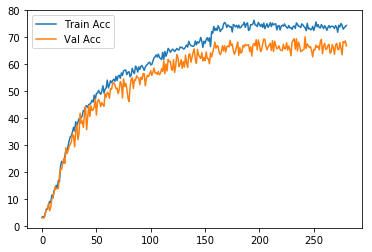

In [29]:
print('best test accuracy: {:.6f}'.format(best_acc122))
with open('model122_A_history_yale.pkl','wb') as f:
    pickle.dump(history122,f)
torch.cuda.empty_cache()    

plt.plot(history122['acc'])
plt.plot(history122['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 70.258 epoch : 243 *


======================================================
##### model 223


In [30]:
# model
torch.cuda.empty_cache()    
best_acc223 = 0
em_iters = [2,2,3]
model223 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history223={'val_acc':[],'acc':[]}
optimizer223 = optim.Adam(model223.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [2, 2, 3] 
stage output:  class_caps 
activation:  o


In [31]:
# model223.load_state_dict(torch.load('caps_train_v3\\model_model223_A_122.pth'))
# history223['val_acc']=history223['val_acc'][:122]
# history223['acc']=history223['acc'][:122]

In [32]:
torch.cuda.empty_cache()    

best_acc223 = mainTrain('model223_A',epochs,model223,history223,
        optimizer223,tolarance=12,previous_epochs=0,best_acc=0, best_epoch = 1)

########### Training model model223_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 3.016484	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.802943	Accuracy: 3.125000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 2.672224	Accuracy: 0.000000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 2.160784	Accuracy: 6.250000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 2.228029	Accuracy: 3.125000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.638212	Accuracy: 3.125000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 2.045597	Accuracy: 3.125000	
Epoch Train-loss : 2.3214, Epoch Train-accuracy : 2.6714
Test Completion: [-------------->     ] 75%
Test set: Average loss: 30.447680, Accuracy: 2.420415 


saving model to yale_face_weights\model_model223_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 2.420 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.98 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 2.200188	Accuracy: 0.000000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 2.017062	Accuracy: 3.125000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 2.046677	Accuracy: 3.125000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 2.288777	Accuracy: 6.250000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.899980	Accuracy: 0.000000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.955033	Accuracy: 0.000000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 2.028991	Accuracy: 0.000000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.996154	Accuracy: 6.250000	
Epoch Train-loss : 2.0217, Epoch Train-accuracy : 3.3770
Test Completion: [-------------->     ] 75%
Test set: Average loss: 30.092846, Accuracy: 2.577395 


saving model to yale_face_weights\model_model223_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 4.722 epoch : 6 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.98 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.794348	Accuracy: 0.000000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 2.179944	Accuracy: 0.000000	
Train Epoch: 

Train Epoch: 19	[0/2452 (0%)]	Loss: 2.110248	Accuracy: 6.250000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 2.361861	Accuracy: 6.250000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.846105	Accuracy: 3.125000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 2.036833	Accuracy: 6.250000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 2.483761	Accuracy: 6.250000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.939821	Accuracy: 0.000000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 2.091002	Accuracy: 6.250000	
Epoch Train-loss : 2.0277, Epoch Train-accuracy : 5.2699
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.393517, Accuracy: 5.308119 


saving model to yale_face_weights\model_model223_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 5.817 epoch : 15 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.715240	Accuracy: 3.125000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 2.070534	Accuracy: 9.375000	
Train Epoch:

Train Epoch: 28	[0/2452 (0%)]	Loss: 2.088571	Accuracy: 12.500000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.815706	Accuracy: 6.250000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.915909	Accuracy: 15.625000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.786479	Accuracy: 6.250000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.772419	Accuracy: 3.125000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.958766	Accuracy: 6.250000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 2.068241	Accuracy: 6.250000	
Epoch Train-loss : 1.9907, Epoch Train-accuracy : 6.5524
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.385108, Accuracy: 8.314471 


saving model to yale_face_weights\model_model223_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 9.444 epoch : 26 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.906480	Accuracy: 6.250000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.638978	Accuracy: 3.125000	
Train Epoc

Train Epoch: 37	[0/2452 (0%)]	Loss: 2.066999	Accuracy: 9.375000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 1.676543	Accuracy: 6.250000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.980511	Accuracy: 9.375000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 2.081410	Accuracy: 9.375000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.896084	Accuracy: 15.625000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 2.266743	Accuracy: 3.125000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 2.379235	Accuracy: 6.250000	
Epoch Train-loss : 1.9719, Epoch Train-accuracy : 10.9879
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.484342, Accuracy: 12.175088 


saving model to yale_face_weights\model_model223_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 12.175 epoch : 37 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 2.353209	Accuracy: 9.375000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 2.023105	Accuracy: 12.500000	
Train E

Train Epoch: 46	[0/2452 (0%)]	Loss: 1.879279	Accuracy: 12.500000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 1.981659	Accuracy: 21.875000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.737380	Accuracy: 25.000000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 2.239955	Accuracy: 9.375000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 1.831666	Accuracy: 15.625000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.902459	Accuracy: 21.875000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 1.919977	Accuracy: 12.500000	
Epoch Train-loss : 1.9370, Epoch Train-accuracy : 13.9113
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.286569, Accuracy: 14.794466 


saving model to yale_face_weights\model_model223_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 14.794 epoch : 46 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 1.966133	Accuracy: 9.375000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 2.132299	Accuracy: 12.500000	
Tra

Train Epoch: 55	[0/2452 (0%)]	Loss: 1.930319	Accuracy: 25.000000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 2.141563	Accuracy: 18.750000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 2.065703	Accuracy: 12.500000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 1.646169	Accuracy: 31.250000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 1.794442	Accuracy: 25.000000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 1.493188	Accuracy: 25.000000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 2.294354	Accuracy: 12.500000	
Epoch Train-loss : 1.8609, Epoch Train-accuracy : 19.2316
Test Completion: [-------------->     ] 75%
Test set: Average loss: 25.065116, Accuracy: 18.187792 


saving model to yale_face_weights\model_model223_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 18.188 epoch : 55 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.937171	Accuracy: 21.875000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 1.831246	Accuracy: 15.625000	


Train Epoch: 64	[0/2452 (0%)]	Loss: 1.503167	Accuracy: 28.125000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 2.345778	Accuracy: 12.500000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 2.094218	Accuracy: 25.000000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 2.064002	Accuracy: 21.875000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 1.840235	Accuracy: 15.625000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 1.966938	Accuracy: 28.125000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.697497	Accuracy: 21.875000	
Epoch Train-loss : 1.8406, Epoch Train-accuracy : 21.8526
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.953353, Accuracy: 20.064252 


saving model to yale_face_weights\model_model223_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 20.451 epoch : 60 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 2.035496	Accuracy: 25.000000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 1.712775	Accuracy: 25.000000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 1.854285	Accuracy: 31.250000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 1.474535	Accuracy: 18.750000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 1.506143	Accuracy: 40.625000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 1.414681	Accuracy: 25.000000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 1.434238	Accuracy: 37.500000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 1.800058	Accuracy: 6.250000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 2.026487	Accuracy: 18.750000	
Epoch Train-loss : 1.7571, Epoch Train-accuracy : 23.6447
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.848481, Accuracy: 21.776431 


saving model to yale_face_weights\model_model223_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 24.825 epoch : 71 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 1.514525	Accuracy: 18.750000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 1.569805	Accuracy: 25.000000	
T

Train Epoch: 82	[0/2452 (0%)]	Loss: 1.840603	Accuracy: 15.625000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 1.597634	Accuracy: 34.375000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 1.814128	Accuracy: 34.375000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 1.884113	Accuracy: 37.500000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 2.203774	Accuracy: 15.625000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 2.028479	Accuracy: 25.000000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 1.797335	Accuracy: 21.875000	
Epoch Train-loss : 1.7808, Epoch Train-accuracy : 27.2009
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.379133, Accuracy: 23.105286 


saving model to yale_face_weights\model_model223_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 27.793 epoch : 81 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 1.784203	Accuracy: 18.750000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 2.164353	Accuracy: 31.250000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 2.174825	Accuracy: 21.875000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 1.538773	Accuracy: 31.250000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 1.877382	Accuracy: 31.250000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 1.649032	Accuracy: 25.000000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 1.767549	Accuracy: 34.375000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 1.703554	Accuracy: 34.375000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 1.846890	Accuracy: 21.875000	
Epoch Train-loss : 1.7477, Epoch Train-accuracy : 31.0764
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.574979, Accuracy: 27.015187 


saving model to yale_face_weights\model_model223_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 28.298 epoch : 88 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 1.725782	Accuracy: 18.750000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 1.613115	Accuracy: 40.625000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 2.179092	Accuracy: 28.125000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 1.708098	Accuracy: 31.250000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 2.083513	Accuracy: 34.375000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 2.596332	Accuracy: 31.250000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 2.267018	Accuracy: 31.250000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 1.735512	Accuracy: 31.250000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 2.398298	Accuracy: 25.000000	
Epoch Train-loss : 1.9709, Epoch Train-accuracy : 32.5941
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.280116, Accuracy: 28.490070 


saving model to yale_face_weights\model_model223_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 31.807 epoch : 97 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 2.734914	Accuracy: 25.000000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 2.601263	Accuracy: 2

Train Epoch: 117	[960/2452 (48%)]	Loss: 2.064213	Accuracy: 43.750000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 1.740893	Accuracy: 25.000000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 2.227845	Accuracy: 34.375000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 1.362701	Accuracy: 53.125000	
Epoch Train-loss : 1.9349, Epoch Train-accuracy : 36.7832
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.019381, Accuracy: 29.627264 


saving model to yale_face_weights\model_model223_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 37.586 epoch : 114 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 1.753933	Accuracy: 40.625000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 2.199611	Accuracy: 25.000000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 2.186209	Accuracy: 31.250000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 2.148030	Accuracy: 28.125000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 2.051193	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 1.545053	Accuracy: 40.625000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 1.998906	Accuracy: 46.875000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 2.095416	Accuracy: 43.750000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 1.317613	Accuracy: 46.875000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 1.943183	Accuracy: 25.000000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 1.420013	Accuracy: 43.750000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 1.888279	Accuracy: 37.500000	
Epoch Train-loss : 1.8966, Epoch Train-accuracy : 38.2953
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.081010, Accuracy: 38.213712 


saving model to yale_face_weights\model_model223_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 40.163 epoch : 120 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.98 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 1.995515	Accuracy: 28.125000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 2.051230	Accuracy: 3

Epoch Train-loss : 1.9055, Epoch Train-accuracy : 41.0450
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.596694, Accuracy: 40.201519 


saving model to yale_face_weights\model_model223_A_134.pth
Current Learning Rate : 9.831855118746746e-05
* Best val Accuracy so far : 40.202 epoch : 134 *
Total 14 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 135	[0/2452 (0%)]	Loss: 2.143008	Accuracy: 34.375000	
Train Epoch: 135	[320/2452 (16%)]	Loss: 1.841693	Accuracy: 34.375000	
Train Epoch: 135	[640/2452 (32%)]	Loss: 2.302964	Accuracy: 46.875000	
Train Epoch: 135	[960/2452 (48%)]	Loss: 1.536445	Accuracy: 46.875000	
Train Epoch: 135	[1280/2452 (65%)]	Loss: 1.950525	Accuracy: 31.250000	
Train Epoch: 135	[1600/2452 (81%)]	Loss: 1.247009	Accuracy: 50.000000	
Train Epoch: 135	[1920/2452 (97%)]	Loss: 2.081650	Accuracy: 56.250000	
Epoch Train-loss : 1.8584, Epoch Train-accuracy : 43.5316
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 143	[640/2452 (32%)]	Loss: 2.064424	Accuracy: 43.750000	
Train Epoch: 143	[960/2452 (48%)]	Loss: 1.632642	Accuracy: 46.875000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 1.731351	Accuracy: 43.750000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 2.318097	Accuracy: 43.750000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 1.881340	Accuracy: 46.875000	
Epoch Train-loss : 1.8420, Epoch Train-accuracy : 46.4270
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.965081, Accuracy: 44.100467 


saving model to yale_face_weights\model_model223_A_143.pth
Current Learning Rate : 9.820663662511245e-05
* Best val Accuracy so far : 46.877 epoch : 139 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 2.140096	Accuracy: 43.750000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 1.942498	Accuracy: 46.875000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 1.984478	Accuracy: 59.375000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 1.919986	Accurac

Train Epoch: 152	[0/2452 (0%)]	Loss: 2.203232	Accuracy: 43.750000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 1.930728	Accuracy: 46.875000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 1.942560	Accuracy: 43.750000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 1.806260	Accuracy: 59.375000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 1.795529	Accuracy: 68.750000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 2.968730	Accuracy: 37.500000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 1.468021	Accuracy: 62.500000	
Epoch Train-loss : 1.9297, Epoch Train-accuracy : 48.4207
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.784051, Accuracy: 42.307973 


saving model to yale_face_weights\model_model223_A_152.pth
Current Learning Rate : 9.809484945345959e-06
* Best val Accuracy so far : 46.877 epoch : 139 *
Total 13 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 2.374741	Accuracy: 50.000000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 1.408967	Accuracy:

Train Epoch: 169	[320/2452 (16%)]	Loss: 2.046541	Accuracy: 53.125000	
Train Epoch: 169	[640/2452 (32%)]	Loss: 2.193259	Accuracy: 62.500000	
Train Epoch: 169	[960/2452 (48%)]	Loss: 1.694838	Accuracy: 50.000000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 1.639287	Accuracy: 40.625000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 1.797235	Accuracy: 53.125000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 2.193387	Accuracy: 46.875000	
Epoch Train-loss : 2.2924, Epoch Train-accuracy : 48.6447
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.734406, Accuracy: 43.479848 


saving model to yale_face_weights\model_model223_A_169.pth
Current Learning Rate : 9.78840429664346e-07
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 48.087 epoch : 154 *
Total 15 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 3.053393	Accuracy: 21.875000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 2.196711	

Epoch Train-loss : 2.4800, Epoch Train-accuracy : 46.6286
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.674199, Accuracy: 45.237660 


saving model to yale_face_weights\model_model223_A_177.pth
Current Learning Rate : 9.778499672911288e-09
* Best val Accuracy so far : 48.087 epoch : 154 *
Total 23 epochs with no improvement in val_acc.
Epoch time: 0.97 mins
Train Epoch: 178	[0/2452 (0%)]	Loss: 2.725852	Accuracy: 46.875000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 2.268637	Accuracy: 50.000000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 2.418970	Accuracy: 43.750000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 3.182669	Accuracy: 43.750000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 2.753806	Accuracy: 43.750000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 2.446886	Accuracy: 34.375000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 1.838479	Accuracy: 59.375000	
Epoch Train-loss : 2.4147, Epoch Train-accuracy : 49.5632
Test Completion: [-------------->     ] 75%
Test set: Average loss:

In [33]:
with open('model223_A_history_yale.pkl','wb') as f:
    pickle.dump(history223,f)
print('best test accuracy: {:.6f}'.format(best_acc223))

best test accuracy: 48.087032


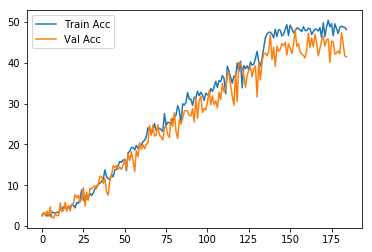

In [34]:
plt.plot(history223['acc'])
plt.plot(history223['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 48.087 epoch : 154 *


=====================================================
#### model 221

In [36]:
# model
torch.cuda.empty_cache()    
best_acc221 = 0
em_iters = [2,2,1]
model221 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history221={'val_acc':[],'acc':[]}
optimizer221 = optim.Adam(model221.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [2, 2, 1] 
stage output:  class_caps 
activation:  o


In [37]:
# model221.load_state_dict(torch.load('face_weights\\model_model221_A_11.pth'))

In [38]:
torch.cuda.empty_cache()    

best_acc221 = mainTrain('model221_A',epochs,model221,history221,optimizer221)

########### Training model model221_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 1.481195	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 1.491760	Accuracy: 0.000000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 1.488547	Accuracy: 6.250000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.508852	Accuracy: 0.000000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 1.501293	Accuracy: 6.250000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 1.498812	Accuracy: 6.250000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.492677	Accuracy: 9.375000	
Epoch Train-loss : 1.4912, Epoch Train-accuracy : 2.9010
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.959272, Accuracy: 3.278329 


saving model to yale_face_weights\model_model221_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 3.278 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 0.92 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.494183	Accuracy: 3.125000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 1.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.590677	Accuracy: 3.125000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.596829	Accuracy: 0.000000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.717126	Accuracy: 0.000000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.595476	Accuracy: 3.125000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.617961	Accuracy: 3.125000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.594552	Accuracy: 6.250000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.634170	Accuracy: 6.250000	
Epoch Train-loss : 1.6035, Epoch Train-accuracy : 4.3347
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.508774, Accuracy: 4.802497 


saving model to yale_face_weights\model_model221_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 6.243 epoch : 7 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.662770	Accuracy: 6.250000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.630105	Accuracy: 9.375000	
Train Epoch: 

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.570933	Accuracy: 12.500000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.566683	Accuracy: 12.500000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.558813	Accuracy: 18.750000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.501101	Accuracy: 12.500000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.733900	Accuracy: 3.125000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.599077	Accuracy: 6.250000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.706725	Accuracy: 6.250000	
Epoch Train-loss : 1.6329, Epoch Train-accuracy : 8.1205
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.796580, Accuracy: 7.456557 


saving model to yale_face_weights\model_model221_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 7.457 epoch : 19 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.583042	Accuracy: 15.625000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.576434	Accuracy: 3.125000	
Train E

Train Epoch: 28	[0/2452 (0%)]	Loss: 1.582428	Accuracy: 9.375000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.646746	Accuracy: 12.500000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.975449	Accuracy: 6.250000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.645902	Accuracy: 3.125000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.546631	Accuracy: 6.250000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.609431	Accuracy: 3.125000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.858906	Accuracy: 3.125000	
Epoch Train-loss : 1.6668, Epoch Train-accuracy : 8.0925
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.004094, Accuracy: 7.571554 


saving model to yale_face_weights\model_model221_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 7.886 epoch : 20 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.90 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.642123	Accuracy: 9.375000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.713077	Accuracy: 18.750000	
Train Epoc

Train Epoch: 37	[0/2452 (0%)]	Loss: 1.594273	Accuracy: 9.375000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 1.744145	Accuracy: 12.500000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.693570	Accuracy: 9.375000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 1.479452	Accuracy: 9.375000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.945547	Accuracy: 6.250000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 1.881648	Accuracy: 3.125000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 1.759657	Accuracy: 6.250000	
Epoch Train-loss : 1.7261, Epoch Train-accuracy : 8.7702
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.297900, Accuracy: 6.947284 


saving model to yale_face_weights\model_model221_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 9.326 epoch : 31 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 1.773950	Accuracy: 6.250000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 1.672787	Accuracy: 9.375000	
Train Epoch

Train Epoch: 46	[0/2452 (0%)]	Loss: 2.020967	Accuracy: 0.000000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 1.918733	Accuracy: 15.625000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 1.813814	Accuracy: 6.250000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 1.875992	Accuracy: 15.625000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 1.812271	Accuracy: 6.250000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.817314	Accuracy: 12.500000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 1.939714	Accuracy: 12.500000	
Epoch Train-loss : 1.9075, Epoch Train-accuracy : 8.7478
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.178601, Accuracy: 7.648218 


saving model to yale_face_weights\model_model221_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 10.187 epoch : 45 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 2.093773	Accuracy: 6.250000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 1.910817	Accuracy: 18.750000	
Train E

Train Epoch: 55	[0/2452 (0%)]	Loss: 2.213433	Accuracy: 6.250000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 1.874925	Accuracy: 18.750000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.979703	Accuracy: 12.500000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 2.058423	Accuracy: 9.375000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 2.409920	Accuracy: 6.250000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 2.123064	Accuracy: 9.375000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 1.976032	Accuracy: 6.250000	
Epoch Train-loss : 2.0077, Epoch Train-accuracy : 9.6270
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.206191, Accuracy: 7.104264 


saving model to yale_face_weights\model_model221_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 10.578 epoch : 50 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.791586	Accuracy: 15.625000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 1.814680	Accuracy: 9.375000	
Train Ep

Train Epoch: 64	[0/2452 (0%)]	Loss: 2.181563	Accuracy: 15.625000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 1.927226	Accuracy: 15.625000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 2.169871	Accuracy: 15.625000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 2.260178	Accuracy: 9.375000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 2.048458	Accuracy: 12.500000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 2.120361	Accuracy: 12.500000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 2.048763	Accuracy: 12.500000	
Epoch Train-loss : 2.1009, Epoch Train-accuracy : 10.1815
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.048516, Accuracy: 9.092071 


saving model to yale_face_weights\model_model221_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 11.359 epoch : 58 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 2.021768	Accuracy: 18.750000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 2.028586	Accuracy: 3.125000	
Tra

Train Epoch: 73	[0/2452 (0%)]	Loss: 2.207450	Accuracy: 12.500000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 2.034548	Accuracy: 18.750000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 2.326106	Accuracy: 3.125000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 2.165762	Accuracy: 12.500000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 2.414569	Accuracy: 12.500000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 2.377798	Accuracy: 12.500000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 2.076522	Accuracy: 15.625000	
Epoch Train-loss : 2.1604, Epoch Train-accuracy : 11.8728
Test Completion: [-------------->     ] 75%
Test set: Average loss: 25.230505, Accuracy: 13.308630 


saving model to yale_face_weights\model_model221_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 13.309 epoch : 73 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 1.979464	Accuracy: 18.750000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 2.265094	Accuracy: 15.625000	
T

Train Epoch: 82	[0/2452 (0%)]	Loss: 2.100380	Accuracy: 25.000000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 2.692405	Accuracy: 6.250000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 2.168437	Accuracy: 12.500000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 2.701925	Accuracy: 3.125000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 2.429490	Accuracy: 9.375000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 1.999640	Accuracy: 9.375000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 2.495646	Accuracy: 15.625000	
Epoch Train-loss : 2.3212, Epoch Train-accuracy : 12.5000
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.771505, Accuracy: 13.346963 


saving model to yale_face_weights\model_model221_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 13.347 epoch : 82 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 1.954927	Accuracy: 21.875000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 2.155414	Accuracy: 6.250000	
Train

Train Epoch: 91	[0/2452 (0%)]	Loss: 2.391349	Accuracy: 18.750000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 2.948119	Accuracy: 9.375000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 2.423986	Accuracy: 9.375000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 2.618564	Accuracy: 9.375000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 2.626749	Accuracy: 15.625000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 2.656179	Accuracy: 9.375000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 2.388963	Accuracy: 9.375000	
Epoch Train-loss : 2.4562, Epoch Train-accuracy : 13.0096
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.397115, Accuracy: 13.503943 


saving model to yale_face_weights\model_model221_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 13.504 epoch : 91 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 2.103438	Accuracy: 18.750000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 2.526262	Accuracy: 9.375000	
Train E

Train Epoch: 100	[0/2452 (0%)]	Loss: 2.323555	Accuracy: 6.250000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 2.823755	Accuracy: 12.500000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 2.418119	Accuracy: 12.500000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 2.617845	Accuracy: 15.625000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 2.311534	Accuracy: 15.625000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 2.806315	Accuracy: 9.375000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 2.383231	Accuracy: 15.625000	
Epoch Train-loss : 2.5053, Epoch Train-accuracy : 14.8017
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.846268, Accuracy: 13.308630 


saving model to yale_face_weights\model_model221_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 14.209 epoch : 93 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 2.424670	Accuracy: 9.375000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 2.435093	Accuracy: 9.37

Train Epoch: 117	[640/2452 (32%)]	Loss: 2.683405	Accuracy: 18.750000	
Train Epoch: 117	[960/2452 (48%)]	Loss: 2.855722	Accuracy: 21.875000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 2.862838	Accuracy: 3.125000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 2.305969	Accuracy: 28.125000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 2.456962	Accuracy: 25.000000	
Epoch Train-loss : 2.7321, Epoch Train-accuracy : 16.9411
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.166029, Accuracy: 16.939252 


saving model to yale_face_weights\model_model221_A_117.pth
Current Learning Rate : 9.853029344654356e-05
* Best val Accuracy so far : 16.939 epoch : 117 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 2.890327	Accuracy: 18.750000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 3.050324	Accuracy: 18.750000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 2.472256	Accuracy: 15.625000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 2.518514	Accuracy

Train Epoch: 126	[0/2452 (0%)]	Loss: 2.519898	Accuracy: 28.125000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 2.845993	Accuracy: 28.125000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 2.590583	Accuracy: 21.875000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 2.657719	Accuracy: 25.000000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 2.997482	Accuracy: 18.750000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 3.353682	Accuracy: 12.500000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 2.725824	Accuracy: 18.750000	
Epoch Train-loss : 2.9092, Epoch Train-accuracy : 17.4899
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.934748, Accuracy: 15.495400 


saving model to yale_face_weights\model_model221_A_126.pth
Current Learning Rate : 9.84181378610859e-05
* Best val Accuracy so far : 16.939 epoch : 117 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 2.849355	Accuracy: 21.875000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 2.862315	Accuracy: 2

Epoch Train-loss : 3.0565, Epoch Train-accuracy : 18.4980
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.965294, Accuracy: 14.323525 


saving model to yale_face_weights\model_model221_A_134.pth
Current Learning Rate : 9.831855118746747e-06
* Best val Accuracy so far : 16.939 epoch : 117 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 135	[0/2452 (0%)]	Loss: 2.569148	Accuracy: 34.375000	
Train Epoch: 135	[320/2452 (16%)]	Loss: 2.935323	Accuracy: 18.750000	
Train Epoch: 135	[640/2452 (32%)]	Loss: 2.696938	Accuracy: 15.625000	
Train Epoch: 135	[960/2452 (48%)]	Loss: 3.285955	Accuracy: 15.625000	
Train Epoch: 135	[1280/2452 (65%)]	Loss: 2.690377	Accuracy: 21.875000	
Train Epoch: 135	[1600/2452 (81%)]	Loss: 3.272944	Accuracy: 15.625000	
Train Epoch: 135	[1920/2452 (97%)]	Loss: 2.723968	Accuracy: 25.000000	
Epoch Train-loss : 3.1348, Epoch Train-accuracy : 17.0195
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 143	[640/2452 (32%)]	Loss: 4.046218	Accuracy: 6.250000	
Train Epoch: 143	[960/2452 (48%)]	Loss: 3.085209	Accuracy: 21.875000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 3.288993	Accuracy: 9.375000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 3.260374	Accuracy: 9.375000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 3.624398	Accuracy: 18.750000	
Epoch Train-loss : 3.3113, Epoch Train-accuracy : 18.4812
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.988065, Accuracy: 17.954147 


saving model to yale_face_weights\model_model221_A_143.pth
Current Learning Rate : 9.820663662511246e-06
* Best val Accuracy so far : 17.954 epoch : 143 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 3.433242	Accuracy: 6.250000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 3.122046	Accuracy: 12.500000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 3.724706	Accuracy: 12.500000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 2.995315	Accuracy: 2

Train Epoch: 152	[0/2452 (0%)]	Loss: 3.544247	Accuracy: 15.625000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 3.275123	Accuracy: 9.375000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 3.561464	Accuracy: 21.875000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 3.406427	Accuracy: 25.000000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 3.927751	Accuracy: 18.750000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 3.888485	Accuracy: 15.625000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 3.268566	Accuracy: 21.875000	
Epoch Train-loss : 3.6212, Epoch Train-accuracy : 17.5683
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.869708, Accuracy: 14.403841 


saving model to yale_face_weights\model_model221_A_152.pth
Current Learning Rate : 9.809484945345959e-06
8 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 17.954 epoch : 143 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 3.428412	Accu

Epoch Train-loss : 3.7839, Epoch Train-accuracy : 17.7979
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.597049, Accuracy: 16.391647 


saving model to yale_face_weights\model_model221_A_160.pth
Current Learning Rate : 9.799558990670854e-07
* Best val Accuracy so far : 18.107 epoch : 155 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 0.90 mins
Train Epoch: 161	[0/2452 (0%)]	Loss: 3.649259	Accuracy: 18.750000	
Train Epoch: 161	[320/2452 (16%)]	Loss: 4.039913	Accuracy: 25.000000	
Train Epoch: 161	[640/2452 (32%)]	Loss: 3.974683	Accuracy: 9.375000	
Train Epoch: 161	[960/2452 (48%)]	Loss: 3.345837	Accuracy: 18.750000	
Train Epoch: 161	[1280/2452 (65%)]	Loss: 3.917878	Accuracy: 15.625000	
Train Epoch: 161	[1600/2452 (81%)]	Loss: 3.518905	Accuracy: 15.625000	
Train Epoch: 161	[1920/2452 (97%)]	Loss: 3.901579	Accuracy: 6.250000	
Epoch Train-loss : 3.8128, Epoch Train-accuracy : 17.2155
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23

Train Epoch: 169	[320/2452 (16%)]	Loss: 4.018354	Accuracy: 15.625000	
Train Epoch: 169	[640/2452 (32%)]	Loss: 3.537945	Accuracy: 18.750000	
Train Epoch: 169	[960/2452 (48%)]	Loss: 4.335780	Accuracy: 18.750000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 3.655913	Accuracy: 25.000000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 3.831389	Accuracy: 12.500000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 3.711566	Accuracy: 18.750000	
Epoch Train-loss : 4.0961, Epoch Train-accuracy : 17.2939
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.832294, Accuracy: 17.601854 


saving model to yale_face_weights\model_model221_A_169.pth
Current Learning Rate : 9.78840429664346e-08
* Best val Accuracy so far : 18.107 epoch : 155 *
Total 14 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 3.889223	Accuracy: 28.125000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 4.487219	Accuracy: 12.500000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 4.427834	Accurac

Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.895488, Accuracy: 14.051548 


saving model to yale_face_weights\model_model221_A_177.pth
Current Learning Rate : 9.778499672911288e-09
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 18.107 epoch : 155 *
Total 22 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 178	[0/2452 (0%)]	Loss: 3.785155	Accuracy: 15.625000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 4.556927	Accuracy: 12.500000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 4.160291	Accuracy: 18.750000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 4.550891	Accuracy: 15.625000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 3.789371	Accuracy: 18.750000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 5.242334	Accuracy: 12.500000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 4.548384	Accuracy: 12.500000	
Epoch Train-loss : 4.3140, Epoch Train-accuracy : 18.6548
Test Completion: [-------------->     ] 75%
Test

Train Epoch: 186	[0/2452 (0%)]	Loss: 4.398961	Accuracy: 18.750000	
Train Epoch: 186	[320/2452 (16%)]	Loss: 4.841175	Accuracy: 15.625000	
Train Epoch: 186	[640/2452 (32%)]	Loss: 4.144946	Accuracy: 18.750000	
Train Epoch: 186	[960/2452 (48%)]	Loss: 5.159505	Accuracy: 6.250000	
Train Epoch: 186	[1280/2452 (65%)]	Loss: 4.388318	Accuracy: 12.500000	
Train Epoch: 186	[1600/2452 (81%)]	Loss: 4.250037	Accuracy: 21.875000	
Train Epoch: 186	[1920/2452 (97%)]	Loss: 4.163313	Accuracy: 28.125000	
Epoch Train-loss : 4.6130, Epoch Train-accuracy : 17.4451
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.817669, Accuracy: 16.353315 


saving model to yale_face_weights\model_model221_A_186.pth
Current Learning Rate : 9.767368950395904e-11
* Best val Accuracy so far : 18.107 epoch : 155 *
Total 31 epochs with no improvement in val_acc.
Epoch time: 0.90 mins
Train Epoch: 187	[0/2452 (0%)]	Loss: 4.951918	Accuracy: 15.625000	
Train Epoch: 187	[320/2452 (16%)]	Loss: 5.153982	Accuracy: 

Epoch Train-loss : 4.8518, Epoch Train-accuracy : 18.4308
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.932648, Accuracy: 13.779571 


saving model to yale_face_weights\model_model221_A_194.pth
Current Learning Rate : 9.75748561176632e-12
* Best val Accuracy so far : 18.188 epoch : 192 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 195	[0/2452 (0%)]	Loss: 5.096230	Accuracy: 12.500000	
Train Epoch: 195	[320/2452 (16%)]	Loss: 4.695824	Accuracy: 18.750000	
Train Epoch: 195	[640/2452 (32%)]	Loss: 4.736132	Accuracy: 12.500000	
Train Epoch: 195	[960/2452 (48%)]	Loss: 5.077163	Accuracy: 15.625000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 4.541577	Accuracy: 28.125000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 4.757143	Accuracy: 21.875000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 4.559185	Accuracy: 18.750000	
Epoch Train-loss : 4.9802, Epoch Train-accuracy : 17.1147
Test Completion: [-------------->     ] 75%
Test set: Average loss: 2

Train Epoch: 203	[320/2452 (16%)]	Loss: 5.101706	Accuracy: 25.000000	
Train Epoch: 203	[640/2452 (32%)]	Loss: 4.961662	Accuracy: 18.750000	
Train Epoch: 203	[960/2452 (48%)]	Loss: 5.029315	Accuracy: 28.125000	
Train Epoch: 203	[1280/2452 (65%)]	Loss: 5.263535	Accuracy: 15.625000	
Train Epoch: 203	[1600/2452 (81%)]	Loss: 5.400856	Accuracy: 12.500000	
Train Epoch: 203	[1920/2452 (97%)]	Loss: 5.280834	Accuracy: 15.625000	
Epoch Train-loss : 5.2201, Epoch Train-accuracy : 18.5484
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.291443, Accuracy: 14.794466 


saving model to yale_face_weights\model_model221_A_203.pth
Current Learning Rate : 9.746378809248004e-13
* Best val Accuracy so far : 18.188 epoch : 192 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 0.90 mins
Train Epoch: 204	[0/2452 (0%)]	Loss: 5.117712	Accuracy: 12.500000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 4.655971	Accuracy: 21.875000	
Train Epoch: 204	[640/2452 (32%)]	Loss: 5.297427	Accura

Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.890850, Accuracy: 14.989778 


saving model to yale_face_weights\model_model221_A_211.pth
Current Learning Rate : 9.736516709979186e-14
* Best val Accuracy so far : 18.188 epoch : 192 *
Total 19 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 212	[0/2452 (0%)]	Loss: 4.728084	Accuracy: 18.750000	
Train Epoch: 212	[320/2452 (16%)]	Loss: 5.601319	Accuracy: 21.875000	
Train Epoch: 212	[640/2452 (32%)]	Loss: 5.826273	Accuracy: 6.250000	
Train Epoch: 212	[960/2452 (48%)]	Loss: 5.277726	Accuracy: 28.125000	
Train Epoch: 212	[1280/2452 (65%)]	Loss: 5.676075	Accuracy: 9.375000	
Train Epoch: 212	[1600/2452 (81%)]	Loss: 5.549226	Accuracy: 3.125000	
Train Epoch: 212	[1920/2452 (97%)]	Loss: 5.966672	Accuracy: 12.500000	
Epoch Train-loss : 5.5446, Epoch Train-accuracy : 18.2460
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.869817, Accuracy: 13.189982 


saving model to yale_face_

Train Epoch: 220	[640/2452 (32%)]	Loss: 5.893885	Accuracy: 12.500000	
Train Epoch: 220	[960/2452 (48%)]	Loss: 5.982337	Accuracy: 28.125000	
Train Epoch: 220	[1280/2452 (65%)]	Loss: 5.520034	Accuracy: 25.000000	
Train Epoch: 220	[1600/2452 (81%)]	Loss: 6.042225	Accuracy: 15.625000	
Train Epoch: 220	[1920/2452 (97%)]	Loss: 5.901389	Accuracy: 12.500000	
Epoch Train-loss : 5.8612, Epoch Train-accuracy : 17.9716
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.736045, Accuracy: 14.480505 


saving model to yale_face_weights\model_model221_A_220.pth
Current Learning Rate : 9.725433776053708e-15
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 18.188 epoch : 192 *
Total 28 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 221	[0/2452 (0%)]	Loss: 5.654765	Accuracy: 15.625000	
Train Epoch: 221	[320/2452 (16%)]	Loss: 5.552660	Accuracy: 9.375000	
Train Epoch: 221	[640/2452 (32%)]	Loss: 5.978629	

Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.855886, Accuracy: 17.483207 


saving model to yale_face_weights\model_model221_A_228.pth
Current Learning Rate : 9.715592870502125e-17
* Best val Accuracy so far : 18.188 epoch : 192 *
Total 36 epochs with no improvement in val_acc.
Epoch time: 0.91 mins
Train Epoch: 229	[0/2452 (0%)]	Loss: 6.429003	Accuracy: 21.875000	
Train Epoch: 229	[320/2452 (16%)]	Loss: 6.013175	Accuracy: 18.750000	
Train Epoch: 229	[640/2452 (32%)]	Loss: 6.158796	Accuracy: 12.500000	
Train Epoch: 229	[960/2452 (48%)]	Loss: 5.454448	Accuracy: 18.750000	
Train Epoch: 229	[1280/2452 (65%)]	Loss: 6.525797	Accuracy: 6.250000	
Train Epoch: 229	[1600/2452 (81%)]	Loss: 5.754234	Accuracy: 15.625000	
Train Epoch: 229	[1920/2452 (97%)]	Loss: 6.247564	Accuracy: 21.875000	
Epoch Train-loss : 6.2623, Epoch Train-accuracy : 17.0699
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.868814, Accuracy: 17.092582 


saving model to yale_fac

In [39]:
print('best test accuracy: {:.6f}'.format(best_acc221))
with open('model221_A_history_yale.pkl','wb') as f:
    pickle.dump(history221,f)

best test accuracy: 18.187792


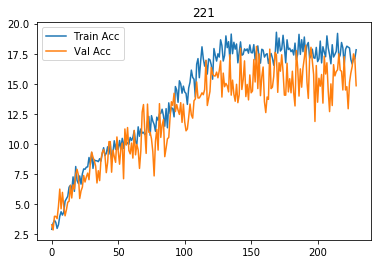

In [40]:
plt.title('221')
plt.plot(history221['acc'])
plt.plot(history221['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 18.188 epoch : 192 *


=====================================================

#### model 2 3 2

In [41]:
# model
torch.cuda.empty_cache()
best_acc232 = 0
em_iters = [2,3,2]
model232 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history232={'val_acc':[],'acc':[]}
optimizer232 = optim.Adam(model232.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K ,input channels= [64, 8, 16, 16, 38, 3, 4, 1] 
iters for routings:  [2, 3, 2] 
stage output:  class_caps 
activation:  o


In [42]:
torch.cuda.empty_cache()

best_acc232= mainTrain('model232_A',epochs,model232,history232,optimizer232)
print('best test accuracy: {:.6f}'.format(best_acc232))

########### Training model model232_A ###########
Train Epoch: 1	[0/2452 (0%)]	Loss: 2.366762	Accuracy: 0.000000	
Train Epoch: 1	[320/2452 (16%)]	Loss: 2.837716	Accuracy: 0.000000	
Train Epoch: 1	[640/2452 (32%)]	Loss: 2.232939	Accuracy: 0.000000	
Train Epoch: 1	[960/2452 (48%)]	Loss: 1.721608	Accuracy: 3.125000	
Train Epoch: 1	[1280/2452 (65%)]	Loss: 1.999762	Accuracy: 3.125000	
Train Epoch: 1	[1600/2452 (81%)]	Loss: 2.054157	Accuracy: 0.000000	
Train Epoch: 1	[1920/2452 (97%)]	Loss: 1.839427	Accuracy: 0.000000	
Epoch Train-loss : 2.0308, Epoch Train-accuracy : 2.3185
Test Completion: [-------------->     ] 75%
Test set: Average loss: 30.071666, Accuracy: 2.068122 


saving model to yale_face_weights\model_model232_A_1.pth
Current Learning Rate : 0.0009998734598238707
* Best val Accuracy so far : 2.068 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 1.06 mins
Train Epoch: 2	[0/2452 (0%)]	Loss: 1.606405	Accuracy: 0.000000	
Train Epoch: 2	[320/2452 (16%)]	Loss: 2.

Train Epoch: 10	[0/2452 (0%)]	Loss: 1.510947	Accuracy: 3.125000	
Train Epoch: 10	[320/2452 (16%)]	Loss: 1.548153	Accuracy: 6.250000	
Train Epoch: 10	[640/2452 (32%)]	Loss: 1.622685	Accuracy: 3.125000	
Train Epoch: 10	[960/2452 (48%)]	Loss: 1.892009	Accuracy: 9.375000	
Train Epoch: 10	[1280/2452 (65%)]	Loss: 1.590813	Accuracy: 0.000000	
Train Epoch: 10	[1600/2452 (81%)]	Loss: 1.755320	Accuracy: 3.125000	
Train Epoch: 10	[1920/2452 (97%)]	Loss: 1.748738	Accuracy: 3.125000	
Epoch Train-loss : 1.6558, Epoch Train-accuracy : 5.1467
Test Completion: [-------------->     ] 75%
Test set: Average loss: 29.441574, Accuracy: 3.864267 


saving model to yale_face_weights\model_model232_A_10.pth
Current Learning Rate : 0.0009987353185543437
* Best val Accuracy so far : 6.128 epoch : 7 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 11	[0/2452 (0%)]	Loss: 1.717705	Accuracy: 0.000000	
Train Epoch: 11	[320/2452 (16%)]	Loss: 1.318436	Accuracy: 3.125000	
Train Epoch: 

Train Epoch: 19	[0/2452 (0%)]	Loss: 1.784629	Accuracy: 12.500000	
Train Epoch: 19	[320/2452 (16%)]	Loss: 1.709311	Accuracy: 0.000000	
Train Epoch: 19	[640/2452 (32%)]	Loss: 1.690469	Accuracy: 3.125000	
Train Epoch: 19	[960/2452 (48%)]	Loss: 1.774216	Accuracy: 9.375000	
Train Epoch: 19	[1280/2452 (65%)]	Loss: 1.503480	Accuracy: 6.250000	
Train Epoch: 19	[1600/2452 (81%)]	Loss: 1.812320	Accuracy: 3.125000	
Train Epoch: 19	[1920/2452 (97%)]	Loss: 1.582414	Accuracy: 15.625000	
Epoch Train-loss : 1.6761, Epoch Train-accuracy : 6.5804
Test Completion: [-------------->     ] 75%
Test set: Average loss: 28.747705, Accuracy: 7.456557 


saving model to yale_face_weights\model_model232_A_19.pth
Current Learning Rate : 0.0009975984728143024
* Best val Accuracy so far : 7.457 epoch : 19 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 20	[0/2452 (0%)]	Loss: 1.526198	Accuracy: 9.375000	
Train Epoch: 20	[320/2452 (16%)]	Loss: 1.637987	Accuracy: 12.500000	
Train Epo

Train Epoch: 28	[0/2452 (0%)]	Loss: 1.462295	Accuracy: 12.500000	
Train Epoch: 28	[320/2452 (16%)]	Loss: 1.540764	Accuracy: 15.625000	
Train Epoch: 28	[640/2452 (32%)]	Loss: 1.488150	Accuracy: 18.750000	
Train Epoch: 28	[960/2452 (48%)]	Loss: 1.405820	Accuracy: 18.750000	
Train Epoch: 28	[1280/2452 (65%)]	Loss: 1.790976	Accuracy: 6.250000	
Train Epoch: 28	[1600/2452 (81%)]	Loss: 1.975863	Accuracy: 15.625000	
Train Epoch: 28	[1920/2452 (97%)]	Loss: 1.622006	Accuracy: 18.750000	
Epoch Train-loss : 1.6490, Epoch Train-accuracy : 11.0943
Test Completion: [-------------->     ] 75%
Test set: Average loss: 27.585810, Accuracy: 10.106966 


saving model to yale_face_weights\model_model232_A_28.pth
Current Learning Rate : 0.0009964629211290652
* Best val Accuracy so far : 10.107 epoch : 28 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 29	[0/2452 (0%)]	Loss: 1.581499	Accuracy: 18.750000	
Train Epoch: 29	[320/2452 (16%)]	Loss: 1.805796	Accuracy: 15.625000	
T

Train Epoch: 37	[0/2452 (0%)]	Loss: 1.379018	Accuracy: 21.875000	
Train Epoch: 37	[320/2452 (16%)]	Loss: 1.700202	Accuracy: 3.125000	
Train Epoch: 37	[640/2452 (32%)]	Loss: 1.731023	Accuracy: 9.375000	
Train Epoch: 37	[960/2452 (48%)]	Loss: 1.546893	Accuracy: 12.500000	
Train Epoch: 37	[1280/2452 (65%)]	Loss: 1.600977	Accuracy: 6.250000	
Train Epoch: 37	[1600/2452 (81%)]	Loss: 1.653882	Accuracy: 6.250000	
Train Epoch: 37	[1920/2452 (97%)]	Loss: 1.491009	Accuracy: 12.500000	
Epoch Train-loss : 1.6181, Epoch Train-accuracy : 13.2897
Test Completion: [-------------->     ] 75%
Test set: Average loss: 26.237159, Accuracy: 14.989778 


saving model to yale_face_weights\model_model232_A_37.pth
Current Learning Rate : 0.0009953286620256279
* Best val Accuracy so far : 14.990 epoch : 37 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 38	[0/2452 (0%)]	Loss: 1.337225	Accuracy: 15.625000	
Train Epoch: 38	[320/2452 (16%)]	Loss: 1.713753	Accuracy: 6.250000	
Train

Train Epoch: 46	[0/2452 (0%)]	Loss: 1.358298	Accuracy: 21.875000	
Train Epoch: 46	[320/2452 (16%)]	Loss: 1.529619	Accuracy: 6.250000	
Train Epoch: 46	[640/2452 (32%)]	Loss: 2.326503	Accuracy: 12.500000	
Train Epoch: 46	[960/2452 (48%)]	Loss: 1.654881	Accuracy: 25.000000	
Train Epoch: 46	[1280/2452 (65%)]	Loss: 1.542145	Accuracy: 18.750000	
Train Epoch: 46	[1600/2452 (81%)]	Loss: 1.878524	Accuracy: 12.500000	
Train Epoch: 46	[1920/2452 (97%)]	Loss: 1.732273	Accuracy: 12.500000	
Epoch Train-loss : 1.6545, Epoch Train-accuracy : 16.2298
Test Completion: [-------------->     ] 75%
Test set: Average loss: 24.920047, Accuracy: 16.314982 


saving model to yale_face_weights\model_model232_A_46.pth
Current Learning Rate : 0.000994195694032664
* Best val Accuracy so far : 18.076 epoch : 43 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 47	[0/2452 (0%)]	Loss: 1.884920	Accuracy: 18.750000	
Train Epoch: 47	[320/2452 (16%)]	Loss: 1.336506	Accuracy: 25.000000	
Tr

Train Epoch: 55	[0/2452 (0%)]	Loss: 1.154034	Accuracy: 25.000000	
Train Epoch: 55	[320/2452 (16%)]	Loss: 1.815000	Accuracy: 9.375000	
Train Epoch: 55	[640/2452 (32%)]	Loss: 1.542876	Accuracy: 18.750000	
Train Epoch: 55	[960/2452 (48%)]	Loss: 1.832622	Accuracy: 6.250000	
Train Epoch: 55	[1280/2452 (65%)]	Loss: 1.659451	Accuracy: 15.625000	
Train Epoch: 55	[1600/2452 (81%)]	Loss: 1.588380	Accuracy: 25.000000	
Train Epoch: 55	[1920/2452 (97%)]	Loss: 1.660122	Accuracy: 21.875000	
Epoch Train-loss : 1.5886, Epoch Train-accuracy : 20.1445
Test Completion: [-------------->     ] 75%
Test set: Average loss: 23.694869, Accuracy: 22.603315 


saving model to yale_face_weights\model_model232_A_55.pth
Current Learning Rate : 0.0009930640156805212
* Best val Accuracy so far : 23.538 epoch : 52 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 56	[0/2452 (0%)]	Loss: 1.474808	Accuracy: 28.125000	
Train Epoch: 56	[320/2452 (16%)]	Loss: 1.400094	Accuracy: 28.125000	
Tr

Train Epoch: 64	[0/2452 (0%)]	Loss: 1.460987	Accuracy: 34.375000	
Train Epoch: 64	[320/2452 (16%)]	Loss: 1.833552	Accuracy: 18.750000	
Train Epoch: 64	[640/2452 (32%)]	Loss: 1.700430	Accuracy: 18.750000	
Train Epoch: 64	[960/2452 (48%)]	Loss: 1.719546	Accuracy: 25.000000	
Train Epoch: 64	[1280/2452 (65%)]	Loss: 1.346164	Accuracy: 34.375000	
Train Epoch: 64	[1600/2452 (81%)]	Loss: 1.609381	Accuracy: 25.000000	
Train Epoch: 64	[1920/2452 (97%)]	Loss: 1.538837	Accuracy: 21.875000	
Epoch Train-loss : 1.5434, Epoch Train-accuracy : 26.5961
Test Completion: [-------------->     ] 75%
Test set: Average loss: 22.525293, Accuracy: 24.587471 


saving model to yale_face_weights\model_model232_A_64.pth
Current Learning Rate : 0.0009919336255012207
* Best val Accuracy so far : 25.993 epoch : 63 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 65	[0/2452 (0%)]	Loss: 1.678873	Accuracy: 18.750000	
Train Epoch: 65	[320/2452 (16%)]	Loss: 1.234272	Accuracy: 18.750000	


Train Epoch: 73	[0/2452 (0%)]	Loss: 1.274938	Accuracy: 43.750000	
Train Epoch: 73	[320/2452 (16%)]	Loss: 1.244780	Accuracy: 34.375000	
Train Epoch: 73	[640/2452 (32%)]	Loss: 1.303051	Accuracy: 43.750000	
Train Epoch: 73	[960/2452 (48%)]	Loss: 1.347995	Accuracy: 25.000000	
Train Epoch: 73	[1280/2452 (65%)]	Loss: 1.412325	Accuracy: 37.500000	
Train Epoch: 73	[1600/2452 (81%)]	Loss: 1.276535	Accuracy: 31.250000	
Train Epoch: 73	[1920/2452 (97%)]	Loss: 1.399928	Accuracy: 34.375000	
Epoch Train-loss : 1.4068, Epoch Train-accuracy : 32.7957
Test Completion: [-------------->     ] 75%
Test set: Average loss: 21.357672, Accuracy: 28.451738 


saving model to yale_face_weights\model_model232_A_73.pth
Current Learning Rate : 0.0009908045220284537
* Best val Accuracy so far : 29.080 epoch : 70 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.06 mins
Train Epoch: 74	[0/2452 (0%)]	Loss: 1.535079	Accuracy: 25.000000	
Train Epoch: 74	[320/2452 (16%)]	Loss: 1.302113	Accuracy: 34.375000	


Train Epoch: 82	[0/2452 (0%)]	Loss: 1.179727	Accuracy: 43.750000	
Train Epoch: 82	[320/2452 (16%)]	Loss: 1.232695	Accuracy: 37.500000	
Train Epoch: 82	[640/2452 (32%)]	Loss: 1.568604	Accuracy: 31.250000	
Train Epoch: 82	[960/2452 (48%)]	Loss: 1.406621	Accuracy: 37.500000	
Train Epoch: 82	[1280/2452 (65%)]	Loss: 1.214449	Accuracy: 25.000000	
Train Epoch: 82	[1600/2452 (81%)]	Loss: 1.515393	Accuracy: 21.875000	
Train Epoch: 82	[1920/2452 (97%)]	Loss: 2.447502	Accuracy: 25.000000	
Epoch Train-loss : 1.4451, Epoch Train-accuracy : 33.8318
Test Completion: [-------------->     ] 75%
Test set: Average loss: 20.322577, Accuracy: 31.538405 


saving model to yale_face_weights\model_model232_A_82.pth
Current Learning Rate : 0.0009896767037975815
* Best val Accuracy so far : 31.538 epoch : 82 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 83	[0/2452 (0%)]	Loss: 1.658951	Accuracy: 34.375000	
Train Epoch: 83	[320/2452 (16%)]	Loss: 1.428872	Accuracy: 46.875000	


Train Epoch: 91	[0/2452 (0%)]	Loss: 1.349539	Accuracy: 43.750000	
Train Epoch: 91	[320/2452 (16%)]	Loss: 1.084273	Accuracy: 40.625000	
Train Epoch: 91	[640/2452 (32%)]	Loss: 1.539332	Accuracy: 31.250000	
Train Epoch: 91	[960/2452 (48%)]	Loss: 1.533200	Accuracy: 28.125000	
Train Epoch: 91	[1280/2452 (65%)]	Loss: 2.037435	Accuracy: 31.250000	
Train Epoch: 91	[1600/2452 (81%)]	Loss: 0.998904	Accuracy: 40.625000	
Train Epoch: 91	[1920/2452 (97%)]	Loss: 1.967459	Accuracy: 34.375000	
Epoch Train-loss : 1.5012, Epoch Train-accuracy : 35.6183
Test Completion: [-------------->     ] 75%
Test set: Average loss: 19.593814, Accuracy: 34.188814 


saving model to yale_face_weights\model_model232_A_91.pth
Current Learning Rate : 0.000988550169345632
* Best val Accuracy so far : 35.874 epoch : 87 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 92	[0/2452 (0%)]	Loss: 1.136726	Accuracy: 43.750000	
Train Epoch: 92	[320/2452 (16%)]	Loss: 1.808137	Accuracy: 37.500000	
T

Train Epoch: 100	[0/2452 (0%)]	Loss: 1.494766	Accuracy: 34.375000	
Train Epoch: 100	[320/2452 (16%)]	Loss: 1.585709	Accuracy: 34.375000	
Train Epoch: 100	[640/2452 (32%)]	Loss: 1.510760	Accuracy: 34.375000	
Train Epoch: 100	[960/2452 (48%)]	Loss: 1.831266	Accuracy: 31.250000	
Train Epoch: 100	[1280/2452 (65%)]	Loss: 1.481520	Accuracy: 31.250000	
Train Epoch: 100	[1600/2452 (81%)]	Loss: 0.874487	Accuracy: 50.000000	
Train Epoch: 100	[1920/2452 (97%)]	Loss: 1.348915	Accuracy: 40.625000	
Epoch Train-loss : 1.4350, Epoch Train-accuracy : 39.0009
Test Completion: [-------------->     ] 75%
Test set: Average loss: 18.793671, Accuracy: 40.630476 


saving model to yale_face_weights\model_model232_A_100.pth
Current Learning Rate : 0.0009874249172112984
* Best val Accuracy so far : 40.630 epoch : 100 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 101	[0/2452 (0%)]	Loss: 1.481129	Accuracy: 31.250000	
Train Epoch: 101	[320/2452 (16%)]	Loss: 1.954013	Accuracy: 

Train Epoch: 117	[960/2452 (48%)]	Loss: 1.487019	Accuracy: 50.000000	
Train Epoch: 117	[1280/2452 (65%)]	Loss: 1.376235	Accuracy: 46.875000	
Train Epoch: 117	[1600/2452 (81%)]	Loss: 1.344232	Accuracy: 50.000000	
Train Epoch: 117	[1920/2452 (97%)]	Loss: 1.378234	Accuracy: 50.000000	
Epoch Train-loss : 1.4287, Epoch Train-accuracy : 45.3965
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.341163, Accuracy: 41.063084 


saving model to yale_face_weights\model_model232_A_117.pth
Current Learning Rate : 0.0009853029344654356
* Best val Accuracy so far : 42.775 epoch : 115 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 118	[0/2452 (0%)]	Loss: 1.545000	Accuracy: 37.500000	
Train Epoch: 118	[320/2452 (16%)]	Loss: 1.336241	Accuracy: 40.625000	
Train Epoch: 118	[640/2452 (32%)]	Loss: 1.424110	Accuracy: 37.500000	
Train Epoch: 118	[960/2452 (48%)]	Loss: 1.293765	Accuracy: 43.750000	
Train Epoch: 118	[1280/2452 (65%)]	Loss: 1.350920	Accura

Train Epoch: 126	[0/2452 (0%)]	Loss: 0.893402	Accuracy: 53.125000	
Train Epoch: 126	[320/2452 (16%)]	Loss: 1.119796	Accuracy: 56.250000	
Train Epoch: 126	[640/2452 (32%)]	Loss: 1.383111	Accuracy: 40.625000	
Train Epoch: 126	[960/2452 (48%)]	Loss: 1.875590	Accuracy: 34.375000	
Train Epoch: 126	[1280/2452 (65%)]	Loss: 1.387376	Accuracy: 43.750000	
Train Epoch: 126	[1600/2452 (81%)]	Loss: 1.889526	Accuracy: 34.375000	
Train Epoch: 126	[1920/2452 (97%)]	Loss: 1.966496	Accuracy: 40.625000	
Epoch Train-loss : 1.4914, Epoch Train-accuracy : 46.1358
Test Completion: [-------------->     ] 75%
Test set: Average loss: 17.386367, Accuracy: 41.174431 


saving model to yale_face_weights\model_model232_A_126.pth
Current Learning Rate : 0.000984181378610859
* Best val Accuracy so far : 44.533 epoch : 125 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 127	[0/2452 (0%)]	Loss: 1.595823	Accuracy: 40.625000	
Train Epoch: 127	[320/2452 (16%)]	Loss: 1.829057	Accuracy: 4

Train Epoch: 143	[960/2452 (48%)]	Loss: 1.344253	Accuracy: 56.250000	
Train Epoch: 143	[1280/2452 (65%)]	Loss: 1.454317	Accuracy: 53.125000	
Train Epoch: 143	[1600/2452 (81%)]	Loss: 2.011714	Accuracy: 50.000000	
Train Epoch: 143	[1920/2452 (97%)]	Loss: 1.107138	Accuracy: 50.000000	
Epoch Train-loss : 1.5019, Epoch Train-accuracy : 49.4960
Test Completion: [-------------->     ] 75%
Test set: Average loss: 16.160691, Accuracy: 49.492553 


saving model to yale_face_weights\model_model232_A_143.pth
Current Learning Rate : 0.0009820663662511245
* Best val Accuracy so far : 49.493 epoch : 143 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 144	[0/2452 (0%)]	Loss: 2.281027	Accuracy: 31.250000	
Train Epoch: 144	[320/2452 (16%)]	Loss: 1.807583	Accuracy: 43.750000	
Train Epoch: 144	[640/2452 (32%)]	Loss: 1.226328	Accuracy: 56.250000	
Train Epoch: 144	[960/2452 (48%)]	Loss: 1.668473	Accuracy: 50.000000	
Train Epoch: 144	[1280/2452 (65%)]	Loss: 1.422260	Accura

Train Epoch: 152	[0/2452 (0%)]	Loss: 2.064699	Accuracy: 43.750000	
Train Epoch: 152	[320/2452 (16%)]	Loss: 1.330872	Accuracy: 43.750000	
Train Epoch: 152	[640/2452 (32%)]	Loss: 1.770473	Accuracy: 34.375000	
Train Epoch: 152	[960/2452 (48%)]	Loss: 2.073001	Accuracy: 37.500000	
Train Epoch: 152	[1280/2452 (65%)]	Loss: 1.970694	Accuracy: 46.875000	
Train Epoch: 152	[1600/2452 (81%)]	Loss: 2.387395	Accuracy: 43.750000	
Train Epoch: 152	[1920/2452 (97%)]	Loss: 1.691750	Accuracy: 56.250000	
Epoch Train-loss : 1.6159, Epoch Train-accuracy : 49.9048
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.402183, Accuracy: 48.550672 


saving model to yale_face_weights\model_model232_A_152.pth
Current Learning Rate : 0.0009809484945345957
* Best val Accuracy so far : 49.803 epoch : 149 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 153	[0/2452 (0%)]	Loss: 1.285239	Accuracy: 62.500000	
Train Epoch: 153	[320/2452 (16%)]	Loss: 1.745001	Accuracy: 

Train Epoch: 169	[960/2452 (48%)]	Loss: 1.954836	Accuracy: 56.250000	
Train Epoch: 169	[1280/2452 (65%)]	Loss: 1.847910	Accuracy: 53.125000	
Train Epoch: 169	[1600/2452 (81%)]	Loss: 1.533488	Accuracy: 56.250000	
Train Epoch: 169	[1920/2452 (97%)]	Loss: 1.590277	Accuracy: 65.625000	
Epoch Train-loss : 1.6083, Epoch Train-accuracy : 53.2874
Test Completion: [-------------->     ] 75%
Test set: Average loss: 15.127173, Accuracy: 48.435675 


saving model to yale_face_weights\model_model232_A_169.pth
Current Learning Rate : 0.0009788404296643457
* Best val Accuracy so far : 53.242 epoch : 166 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 170	[0/2452 (0%)]	Loss: 1.235996	Accuracy: 53.125000	
Train Epoch: 170	[320/2452 (16%)]	Loss: 1.478336	Accuracy: 59.375000	
Train Epoch: 170	[640/2452 (32%)]	Loss: 1.453159	Accuracy: 53.125000	
Train Epoch: 170	[960/2452 (48%)]	Loss: 1.518635	Accuracy: 40.625000	
Train Epoch: 170	[1280/2452 (65%)]	Loss: 1.308912	Accura

Train Epoch: 178	[0/2452 (0%)]	Loss: 1.410336	Accuracy: 75.000000	
Train Epoch: 178	[320/2452 (16%)]	Loss: 2.101664	Accuracy: 46.875000	
Train Epoch: 178	[640/2452 (32%)]	Loss: 1.770555	Accuracy: 37.500000	
Train Epoch: 178	[960/2452 (48%)]	Loss: 1.163302	Accuracy: 62.500000	
Train Epoch: 178	[1280/2452 (65%)]	Loss: 1.356493	Accuracy: 56.250000	
Train Epoch: 178	[1600/2452 (81%)]	Loss: 1.691870	Accuracy: 56.250000	
Train Epoch: 178	[1920/2452 (97%)]	Loss: 2.109915	Accuracy: 53.125000	
Epoch Train-loss : 1.6885, Epoch Train-accuracy : 52.9346
Test Completion: [-------------->     ] 75%
Test set: Average loss: 14.760713, Accuracy: 52.341925 


saving model to yale_face_weights\model_model232_A_178.pth
Current Learning Rate : 0.0009777262299840394
* Best val Accuracy so far : 53.242 epoch : 166 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 179	[0/2452 (0%)]	Loss: 1.349900	Accuracy: 56.250000	
Train Epoch: 179	[320/2452 (16%)]	Loss: 1.501015	Accuracy:

Train Epoch: 195	[960/2452 (48%)]	Loss: 1.414148	Accuracy: 56.250000	
Train Epoch: 195	[1280/2452 (65%)]	Loss: 1.556475	Accuracy: 71.875000	
Train Epoch: 195	[1600/2452 (81%)]	Loss: 1.859842	Accuracy: 50.000000	
Train Epoch: 195	[1920/2452 (97%)]	Loss: 1.753749	Accuracy: 59.375000	
Epoch Train-loss : 1.8382, Epoch Train-accuracy : 56.3396
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.537299, Accuracy: 56.359521 


saving model to yale_face_weights\model_model232_A_195.pth
Current Learning Rate : 0.0009756250897818424
* Best val Accuracy so far : 56.360 epoch : 195 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 196	[0/2452 (0%)]	Loss: 1.653421	Accuracy: 59.375000	
Train Epoch: 196	[320/2452 (16%)]	Loss: 1.687916	Accuracy: 59.375000	
Train Epoch: 196	[640/2452 (32%)]	Loss: 2.143865	Accuracy: 53.125000	
Train Epoch: 196	[960/2452 (48%)]	Loss: 2.674190	Accuracy: 43.750000	
Train Epoch: 196	[1280/2452 (65%)]	Loss: 2.229062	Accura

Train Epoch: 204	[0/2452 (0%)]	Loss: 1.935942	Accuracy: 53.125000	
Train Epoch: 204	[320/2452 (16%)]	Loss: 1.884852	Accuracy: 56.250000	
Train Epoch: 204	[640/2452 (32%)]	Loss: 2.826026	Accuracy: 43.750000	
Train Epoch: 204	[960/2452 (48%)]	Loss: 3.061595	Accuracy: 53.125000	
Train Epoch: 204	[1280/2452 (65%)]	Loss: 1.564567	Accuracy: 59.375000	
Train Epoch: 204	[1600/2452 (81%)]	Loss: 2.490039	Accuracy: 56.250000	
Train Epoch: 204	[1920/2452 (97%)]	Loss: 2.210495	Accuracy: 46.875000	
Epoch Train-loss : 1.8301, Epoch Train-accuracy : 57.1685
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.587125, Accuracy: 54.211083 


saving model to yale_face_weights\model_model232_A_204.pth
Current Learning Rate : 0.0009745145500756855
* Best val Accuracy so far : 56.360 epoch : 195 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 205	[0/2452 (0%)]	Loss: 1.590132	Accuracy: 56.250000	
Train Epoch: 205	[320/2452 (16%)]	Loss: 1.243867	Accuracy: 

Epoch Train-loss : 1.8740, Epoch Train-accuracy : 59.6214
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.498896, Accuracy: 53.712763 


saving model to yale_face_weights\model_model232_A_212.pth
Current Learning Rate : 9.735284649439816e-05
* Best val Accuracy so far : 56.360 epoch : 195 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 213	[0/2452 (0%)]	Loss: 1.549096	Accuracy: 68.750000	
Train Epoch: 213	[320/2452 (16%)]	Loss: 1.700133	Accuracy: 56.250000	
Train Epoch: 213	[640/2452 (32%)]	Loss: 1.759725	Accuracy: 62.500000	
Train Epoch: 213	[960/2452 (48%)]	Loss: 2.035969	Accuracy: 59.375000	
Train Epoch: 213	[1280/2452 (65%)]	Loss: 1.350242	Accuracy: 78.125000	
Train Epoch: 213	[1600/2452 (81%)]	Loss: 1.610001	Accuracy: 65.625000	
Train Epoch: 213	[1920/2452 (97%)]	Loss: 1.513806	Accuracy: 71.875000	
Epoch Train-loss : 1.7970, Epoch Train-accuracy : 60.8031
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 221	[640/2452 (32%)]	Loss: 1.993408	Accuracy: 62.500000	
Train Epoch: 221	[960/2452 (48%)]	Loss: 2.383901	Accuracy: 68.750000	
Train Epoch: 221	[1280/2452 (65%)]	Loss: 2.134783	Accuracy: 56.250000	
Train Epoch: 221	[1600/2452 (81%)]	Loss: 1.699338	Accuracy: 68.750000	
Train Epoch: 221	[1920/2452 (97%)]	Loss: 1.527579	Accuracy: 62.500000	
Epoch Train-loss : 1.9103, Epoch Train-accuracy : 62.4888
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.902835, Accuracy: 58.511609 


saving model to yale_face_weights\model_model232_A_221.pth
Current Learning Rate : 9.724203117950748e-05
* Best val Accuracy so far : 59.917 epoch : 217 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 222	[0/2452 (0%)]	Loss: 1.333290	Accuracy: 68.750000	
Train Epoch: 222	[320/2452 (16%)]	Loss: 1.771779	Accuracy: 71.875000	
Train Epoch: 222	[640/2452 (32%)]	Loss: 2.389257	Accuracy: 62.500000	
Train Epoch: 222	[960/2452 (48%)]	Loss: 1.494125	Accurac

Train Epoch: 230	[0/2452 (0%)]	Loss: 2.413503	Accuracy: 46.875000	
Train Epoch: 230	[320/2452 (16%)]	Loss: 1.431493	Accuracy: 56.250000	
Train Epoch: 230	[640/2452 (32%)]	Loss: 2.144588	Accuracy: 53.125000	
Train Epoch: 230	[960/2452 (48%)]	Loss: 2.935143	Accuracy: 43.750000	
Train Epoch: 230	[1280/2452 (65%)]	Loss: 1.643563	Accuracy: 65.625000	
Train Epoch: 230	[1600/2452 (81%)]	Loss: 2.116217	Accuracy: 56.250000	
Train Epoch: 230	[1920/2452 (97%)]	Loss: 1.812860	Accuracy: 75.000000	
Epoch Train-loss : 1.9685, Epoch Train-accuracy : 63.3737
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.658140, Accuracy: 58.783587 


saving model to yale_face_weights\model_model232_A_230.pth
Current Learning Rate : 9.71313420040617e-05
* Best val Accuracy so far : 60.109 epoch : 225 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 231	[0/2452 (0%)]	Loss: 1.689170	Accuracy: 53.125000	
Train Epoch: 231	[320/2452 (16%)]	Loss: 1.606094	Accuracy: 5

Train Epoch: 247	[320/2452 (16%)]	Loss: 1.878654	Accuracy: 59.375000	
Train Epoch: 247	[640/2452 (32%)]	Loss: 2.500000	Accuracy: 71.875000	
Train Epoch: 247	[960/2452 (48%)]	Loss: 2.672547	Accuracy: 59.375000	
Train Epoch: 247	[1280/2452 (65%)]	Loss: 2.498251	Accuracy: 56.250000	
Train Epoch: 247	[1600/2452 (81%)]	Loss: 1.642845	Accuracy: 59.375000	
Train Epoch: 247	[1920/2452 (97%)]	Loss: 2.160110	Accuracy: 65.625000	
Epoch Train-loss : 2.2137, Epoch Train-accuracy : 63.4521
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.655883, Accuracy: 62.019932 


saving model to yale_face_weights\model_model232_A_247.pth
Current Learning Rate : 9.692260610098441e-06
* Best val Accuracy so far : 62.020 epoch : 247 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 248	[0/2452 (0%)]	Loss: 1.968859	Accuracy: 56.250000	
Train Epoch: 248	[320/2452 (16%)]	Loss: 1.898867	Accuracy: 56.250000	
Train Epoch: 248	[640/2452 (32%)]	Loss: 2.378453	Accura

Train Epoch: 256	[0/2452 (0%)]	Loss: 2.816610	Accuracy: 53.125000	
Train Epoch: 256	[320/2452 (16%)]	Loss: 2.044956	Accuracy: 75.000000	
Train Epoch: 256	[640/2452 (32%)]	Loss: 2.797739	Accuracy: 65.625000	
Train Epoch: 256	[960/2452 (48%)]	Loss: 2.860797	Accuracy: 59.375000	
Train Epoch: 256	[1280/2452 (65%)]	Loss: 2.634114	Accuracy: 62.500000	
Train Epoch: 256	[1600/2452 (81%)]	Loss: 2.387928	Accuracy: 65.625000	
Train Epoch: 256	[1920/2452 (97%)]	Loss: 2.940522	Accuracy: 59.375000	
Epoch Train-loss : 2.3782, Epoch Train-accuracy : 66.3306
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.671554, Accuracy: 61.629307 


saving model to yale_face_weights\model_model232_A_256.pth
Current Learning Rate : 9.681228052241262e-06
8 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 62.020 epoch : 247 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 257	[0/2452 (0%)]	Loss: 2.613472	Acc

Epoch Train-loss : 2.5741, Epoch Train-accuracy : 65.1882
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.998151, Accuracy: 56.792129 


saving model to yale_face_weights\model_model232_A_264.pth
Current Learning Rate : 9.671431877275777e-07
7 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 62.020 epoch : 247 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 265	[0/2452 (0%)]	Loss: 2.358623	Accuracy: 71.875000	
Train Epoch: 265	[320/2452 (16%)]	Loss: 1.959658	Accuracy: 71.875000	
Train Epoch: 265	[640/2452 (32%)]	Loss: 2.474028	Accuracy: 71.875000	
Train Epoch: 265	[960/2452 (48%)]	Loss: 2.319790	Accuracy: 59.375000	
Train Epoch: 265	[1280/2452 (65%)]	Loss: 2.149758	Accuracy: 71.875000	
Train Epoch: 265	[1600/2452 (81%)]	Loss: 2.834116	Accuracy: 78.125000	
Train Epoch: 265	[1920/2452 (97%)]	Loss: 2.439796	Accuracy: 78.125000	
Epoch Train-loss : 2.5800, Epoch Train-accuracy 

Train Epoch: 273	[320/2452 (16%)]	Loss: 1.898302	Accuracy: 68.750000	
Train Epoch: 273	[640/2452 (32%)]	Loss: 3.210787	Accuracy: 50.000000	
Train Epoch: 273	[960/2452 (48%)]	Loss: 2.940379	Accuracy: 56.250000	
Train Epoch: 273	[1280/2452 (65%)]	Loss: 2.635990	Accuracy: 65.625000	
Train Epoch: 273	[1600/2452 (81%)]	Loss: 2.493366	Accuracy: 71.875000	
Train Epoch: 273	[1920/2452 (97%)]	Loss: 2.929990	Accuracy: 71.875000	
Epoch Train-loss : 2.7050, Epoch Train-accuracy : 65.2386
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.969888, Accuracy: 57.765040 


saving model to yale_face_weights\model_model232_A_273.pth
Current Learning Rate : 9.660423028459162e-08
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 63.854 epoch : 266 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 274	[0/2452 (0%)]	Loss: 2.910389	Accuracy: 59.375000	
Train Epoch: 274	[320/2452 (16%)]	Loss: 2.260596	

Epoch Train-loss : 2.9190, Epoch Train-accuracy : 63.6929
Test Completion: [-------------->     ] 75%
Test set: Average loss: 13.001696, Accuracy: 56.834112 


saving model to yale_face_weights\model_model232_A_281.pth
Current Learning Rate : 9.650647905539145e-10
* Best val Accuracy so far : 63.854 epoch : 266 *
Total 15 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 282	[0/2452 (0%)]	Loss: 2.964869	Accuracy: 59.375000	
Train Epoch: 282	[320/2452 (16%)]	Loss: 3.728895	Accuracy: 59.375000	
Train Epoch: 282	[640/2452 (32%)]	Loss: 2.522424	Accuracy: 59.375000	
Train Epoch: 282	[960/2452 (48%)]	Loss: 2.574221	Accuracy: 75.000000	
Train Epoch: 282	[1280/2452 (65%)]	Loss: 2.275954	Accuracy: 75.000000	
Train Epoch: 282	[1600/2452 (81%)]	Loss: 3.077187	Accuracy: 50.000000	
Train Epoch: 282	[1920/2452 (97%)]	Loss: 2.894218	Accuracy: 81.250000	
Epoch Train-loss : 2.9708, Epoch Train-accuracy : 63.8553
Test Completion: [-------------->     ] 75%
Test set: Average loss:

Train Epoch: 290	[320/2452 (16%)]	Loss: 2.985368	Accuracy: 78.125000	
Train Epoch: 290	[640/2452 (32%)]	Loss: 4.232763	Accuracy: 56.250000	
Train Epoch: 290	[960/2452 (48%)]	Loss: 2.721866	Accuracy: 75.000000	
Train Epoch: 290	[1280/2452 (65%)]	Loss: 2.550949	Accuracy: 65.625000	
Train Epoch: 290	[1600/2452 (81%)]	Loss: 2.943823	Accuracy: 65.625000	
Train Epoch: 290	[1920/2452 (97%)]	Loss: 2.684261	Accuracy: 78.125000	
Epoch Train-loss : 3.2628, Epoch Train-accuracy : 63.7433
Test Completion: [-------------->     ] 75%
Test set: Average loss: 12.576444, Accuracy: 56.520152 


saving model to yale_face_weights\model_model232_A_290.pth
Current Learning Rate : 9.639662714812208e-11
* Best val Accuracy so far : 63.854 epoch : 266 *
Total 24 epochs with no improvement in val_acc.
Epoch time: 1.05 mins
Train Epoch: 291	[0/2452 (0%)]	Loss: 4.189983	Accuracy: 50.000000	
Train Epoch: 291	[320/2452 (16%)]	Loss: 3.520372	Accuracy: 59.375000	
Train Epoch: 291	[640/2452 (32%)]	Loss: 2.657410	Accura

KeyboardInterrupt: 

In [43]:
with open('model232_A_history_yale.pkl','wb') as f:
    pickle.dump(history232,f)
torch.cuda.empty_cache()    

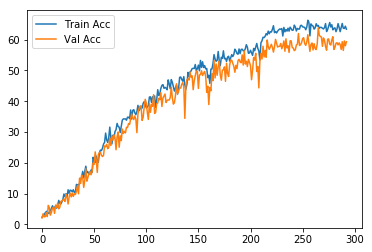

In [44]:
plt.plot(history232['acc'])
plt.plot(history232['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 63.854 epoch : 266 *
